# Quality Control prediction for incoming goods.
 # - modeling/class weights_branch

### **Grzegorz Kowalczyk**
#### 01/08/2024

* **1 Introduction**
* **2 Load and check data**
    * 2.1 Load data
    * 2.2 Data dictionary
    * 2.3 Data types, empty strings
    * 2.4 Null and missing values
    * 2.5 Early CatBoost prediction
    * 2.5 Data distribution
* **3 Data preprocessing**
    * 3.1 Data cleaning
* **4 Filling missing Values**
* **5 Outlier detection and removal**      
* **6 Feature analysis**
    * 6.1 Numerical values
      
        * pcs_pck - log transformation and MinMax: pcs_pck_scaler
        * pcs_length_mm - bins
        * overall_weight_kg - log transformation
        * quantity_pcs - bins
        * pack_weight_kg - log transformation and MinMax: pack_weight_scaler
        * delivered_pcs_pack - dropped
  
    * 6.2 Categorical values
      
        * name
        * shape_no
        * drawing_no
        * surface_finish
        * supplier
  
* **7 Modeling**
    * 7.1 Simple modeling
        * Cross validate models
        * Hyperparameter tuning for best models
        * Plot learning curves
        * Feature importance of the tree-based classifiers
    * 7.2 Ensemble modeling
        * Combining models
    * 7.3 Prediction
        * Predict low occurance classes


## 1. Introduction
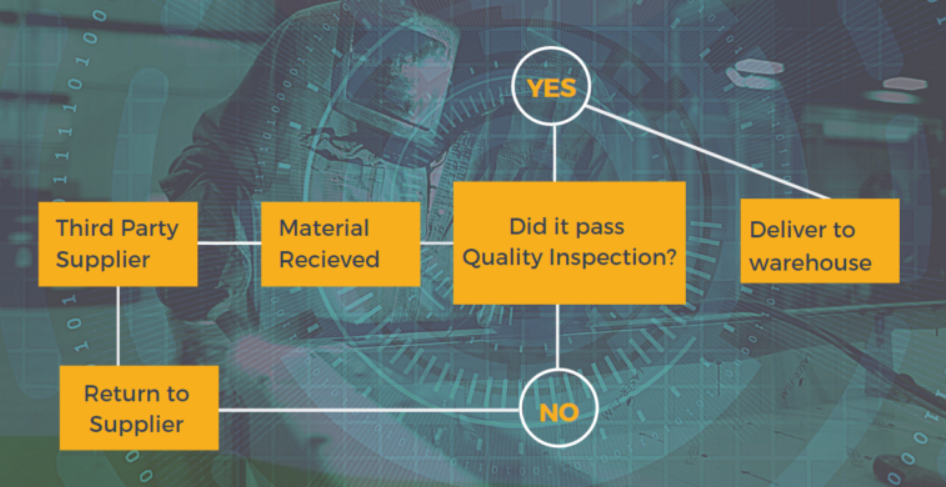



Imagine busy factories, buzzing with activity as products roll off the production line. To keep things running smoothly, these factories rely on suppliers from all over the world, sometimes mixing up where they get their stuff to stay flexible. Beeing diverse in context of suppliers, and realying on them all is not possible without incoming goods quality control. 

Now, let's dive into our project: We're exploring the world of manufacturing, focusing on aluminum LED profiles that come in various shapes, lengths, and colors, sourced from different suppliers, each with its own lead times. These sleek lighting fixtures play a crucial role in modern lighting solutions, but ensuring their quality isn't straightforward. Not only does it serve a decorative role, requiring high surface finish standards, but it also entails numerous dimensions and tight tolerances for fitting counterparts. Conducting quality inspections on large deliveries can thus be both time-consuming and challenging.

In a competitive market, where availability and overall quality often take precedence over price, our task becomes even more crucial. Additionally, considering the delivery lead time, which can vary from 5 to 20 weeks in some cases, and pricing fluctuations tied to LME prices (London Metal Exchange), highlights the hurdles such businesses face. It also underscores how subpar products (labeled 'NOK') can significantly impact availability, thereby affecting the entire business, especially since the logistics objective is to minimize stock levels.

Our mission? To put it simply: To make a smart computer program that can tell us if incoming stuff is good or bad. Basically, we want it to say 'OK' or 'Not OK' when we show it the order we made or want to make.

But here's where it gets exciting: project has the potential to make a significant impact across various aspects of the business. Imagine the excitement when quality personnel can accurately predict the quality of shipments before they even arrive, empowering them to take proactive measures or change their whole quality inspection strategy. Picture shipping experts having access to these predictions before placing orders, streamlining processes and possibly reducing costs. Additionally, think about the benefits for product designers who can identify common issues leading to 'NOK' products and incorporate solutions into future designs, resulting in smoother production processes and higher-quality end products. It's clear that this little project has the potential to influence operations and drive positive outcomes across the board.

Hello, I'm Grzegorz Kowalczyk. With over a decade of experience in various roles within the Quality department of a manufacturing companies, I've honed my expertise in ensuring products meet stringent quality standards. For the past five years, I've served as the head of the department, overseeing quality assurance throughout every stage of the production process. It's worth noting that while our data is authentic, we've taken measures to obscure specific details to uphold confidentiality.

In [2]:
import pandas as pd
# pd.set_option('display.max_rows', None)
import numpy as np
import regex as re
from datetime import datetime, timedelta
from random import randint
import missingno
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format
# !pip install openpyxl
# !pip install regex
# !pip install imbalanced-learn

## 2. Load and check data

So, here's the lowdown on our dataset: it's basically our Quality Control (QC) Excel file, filled to the brim with insights from real-life inspections. Think of it as a snapshot of six years' worth of shipments getting the once-over.

We're talking about a whopping 6448 entries in total, covering every inspection we've ever done. Now, not all columns are created equal – only three of them a beeing shown as numeric type and by just looking at columns we know that it aint the truth.

But let me tell you, this dataset isn't just a walk in the park. It's more like a rollercoaster ride through the ups and downs of human error. We've got everything from pesky NaNs (that's "Not a Number") to weird symbols, sneaky white spaces, and even some data that's been shifted out of place.

While a substantial portion of this mess was already pre-processed during the encoding phase (which, for confidentiality reasons, I can't detail here), there's still plenty of work to be done before we can harness its full potential.

So yeah,it of a mess, but hey, that's where the fun begins, right? Time to roll up our sleeves and dive into the chaos, because buried beneath all those errors lies the key to unlocking some serious isghts.

### 2.1 load data

In [3]:
df = pd.read_excel('../Github depo/QC_encoded_data.xlsx')

In [4]:
df.head()

,date,finish,delivered_pcs_pack,pack_weight_kg,OK_NOK,pcs_lenght_mm,quantity_pcs,overal_weight_kg,pcs_pck,name_e,drawing_no_e,shape_no_e,supplier_e
0,"13,01,2017",color2,NaN,NaN,NOK,NaN,NaN,NaN,40.00,Lepus,DR0,SH0,SU0
1,"13,01,2017",color2,NaN,NaN,NOK,NaN,NaN,NaN,40.00,Sargas,DR1,SH1,SU0
2,"13,01,2017",color2,NaN,NaN,NOK,NaN,NaN,NaN,40.00,Lepus,DR0,SH0,SU0
3,"13,01,2017",color2,NaN,NaN,NOK,NaN,NaN,NaN,40.00,Lepus,DR0,SH0,SU0
4,"19,01,2017",color2,NaN,NaN,NOK,NaN,NaN,NaN,40.00,Hercules2,DR2,SH2,SU1


In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                6403 non-null   object 
 1   finish              6448 non-null   object 
 2   delivered_pcs_pack  4807 non-null   object 
 3   pack_weight_kg      2411 non-null   object 
 4   OK_NOK              6448 non-null   object 
 5   pcs_lenght_mm       4514 non-null   float64
 6   quantity_pcs        4514 non-null   object 
 7   overal_weight_kg    4488 non-null   float64
 8   pcs_pck             6350 non-null   float64
 9   name_e              6448 non-null   object 
 10  drawing_no_e        6448 non-null   object 
 11  shape_no_e          6448 non-null   object 
 12  supplier_e          6448 non-null   object 
dtypes: float64(3), object(10)
memory usage: 3.4 MB


Lets rename and rearenge the columns

In [6]:
new_order = ['OK_NOK','date', 'name_e', 'shape_no_e', 'drawing_no_e', 'finish', 'supplier_e', 'pcs_pck','delivered_pcs_pack', 'pack_weight_kg', 
       'pcs_lenght_mm', 'quantity_pcs', 'overal_weight_kg']

In [7]:
df = df[new_order]

In [8]:
df = df.rename(columns={'overal_weight_kg': 'overall_weight_kg', 'pcs_pck': 'pcs_pack','name_e' : 'name', 'shape_no_e' : 'shape_no', 'drawing_no_e': 'drawing_no', 'supplier_e': 'supplier', 'finish': 'surface_finish'})

In [9]:
df.head()

,OK_NOK,date,name,shape_no,drawing_no,surface_finish,supplier,pcs_pack,delivered_pcs_pack,pack_weight_kg,pcs_lenght_mm,quantity_pcs,overall_weight_kg
0,NOK,"13,01,2017",Lepus,SH0,DR0,color2,SU0,40.00,NaN,NaN,NaN,NaN,NaN
1,NOK,"13,01,2017",Sargas,SH1,DR1,color2,SU0,40.00,NaN,NaN,NaN,NaN,NaN
2,NOK,"13,01,2017",Lepus,SH0,DR0,color2,SU0,40.00,NaN,NaN,NaN,NaN,NaN
3,NOK,"13,01,2017",Lepus,SH0,DR0,color2,SU0,40.00,NaN,NaN,NaN,NaN,NaN
4,NOK,"19,01,2017",Hercules2,SH2,DR2,color2,SU1,40.00,NaN,NaN,NaN,NaN,NaN


Describe function finds only 3 numeric features.

In [10]:
df.describe()

,pcs_pack,pcs_lenght_mm,overall_weight_kg
count,6350.00,4514.00,4488.00
mean,38.54,4078.38,438.28
std,22.97,227.00,226.47
min,2.00,1500.00,0.00
25%,20.00,4050.00,258.39
50%,40.00,4150.00,450.36
75%,40.00,4150.00,568.22
max,100.00,5100.00,1702.41


## 2.2 Data dictionary

* 0.   **OK_NOK**:
      This column contains a target label   
* 1.   **date**:
      Date of delivery
* 2.   **name**:
      This column consist of aluminum profile names
* 3.   **shape_no**:
      Number that defines shape of the aluminium profile.
      Shape itself dosn't describe the final product because many suppliers can deliver the same shape in many colours and at different lenghts
* 4.   **drawing_no**:
      Describes a shape and supplier but dosn't contain information about colours and different lenghts
* 5.   **surface_finish**:
      Information about the colour of the profile
* 6.   **supplier**:
      Name of the supplier
* 7.   **pcs_pack**:
      Number of aluminium profiles that should be delivered in one package
* 8.   **delivered_pcs_pack**:
      Number of aluminium profiles that ware delivered in one package
* 9.   **pack_weight_kg**:
      Weight of one package
* 10.  **pcs_lenght_mm**:
      Lenght of the aluminium profiles
* 11.  **quantity_pcs**:
      How many pcs where delivered 
* 12.  **overall_weight_kg**:
      The overal weight delivered profiles

### 2.3 Early CatBoost algorithm prediction

Before diving into extensive data preprocessing, we often kickstart our analysis by running a preliminary CatBoost algorithm. This approach serves multiple purposes:

1. **Baseline Performance Assessment**: By applying CatBoost to our raw dataset, we obtain initial performance metrics that serve as a baseline for comparison. These metrics, including accuracy, precision, recall, and F1 score, provide insights into the algorithm's performance on unprocessed data.

2. **Identification of Data Challenges**: Running CatBoost early allows us to identify potential challenges within the dataset. Any significant discrepancies or anomalies in the performance metrics may indicate underlying issues such as data imbalance, missing values, or feature engineering requirements.

3. **Hypothesis Generation**: The initial results from CatBoost can spark hypotheses regarding feature importance and model behavior. Observing which features CatBoost deems significant in its initial run can guide our subsequent data preprocessing efforts and feature selection strategies.

4. **Quick Iterative Feedback Loop**: Running CatBoost early facilitates a quick iterative feedback loop. We can swiftly experiment with different preprocessing techniques and feature engineering approaches, iteratively refining our model based on the initial insights gained.

In this preliminary run, we split the dataset into training and testing sets, with 80% for training and 20% for testing. We employ CatBoost with categorical features specified and evaluate its performance using various metrics. Ultimately, we aim to gain initial insights into the dataset's predictability and establish a foundation for further model refinement and optimization.


Transforming target labels into binary format for classification.
 Now, our project's focus revolves around a clear distinction: 'OK' as 1 and 'NOK' as 0.

In [11]:
df['OK_NOK'] = df['OK_NOK'].map({'OK': 1, 'NOK': 0})

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier


df.delivered_pcs_pack = df.delivered_pcs_pack.astype(str)
df.pack_weight_kg = df.pack_weight_kg.astype(str)
y = df['OK_NOK']
X = df.drop(['OK_NOK', 'date'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


cat_features = ['name','shape_no','drawing_no', 'surface_finish', 'supplier', 'delivered_pcs_pack','pack_weight_kg']

catb = CatBoostClassifier(cat_features=cat_features,random_state=42)

#Training the model
catb_model = catb.fit(X_train, y_train, verbose=True)

#Predict
ecat_pred = catb_model.predict(X_test)

#Scoring metrics
ecat_accuracy = accuracy_score(y_test, ecat_pred)
ecat_precision = precision_score(y_test, ecat_pred)
ecat_recall = recall_score(y_test, ecat_pred)
ecat_f1 = f1_score(y_test, ecat_pred,pos_label=1)
ecat_roc_auc = roc_auc_score(y_test, ecat_pred)

ecat_precision_negative = precision_score(y_test, ecat_pred, pos_label=0)
ecat_f1_negative = f1_score(y_test, ecat_pred, pos_label=0)

Learning rate set to 0.020757
0:	learn: 0.6768825	total: 166ms	remaining: 2m 45s
1:	learn: 0.6622030	total: 180ms	remaining: 1m 29s
2:	learn: 0.6476796	total: 196ms	remaining: 1m 5s
3:	learn: 0.6336795	total: 220ms	remaining: 54.9s
4:	learn: 0.6197437	total: 244ms	remaining: 48.5s
5:	learn: 0.6073387	total: 258ms	remaining: 42.8s
6:	learn: 0.5944796	total: 282ms	remaining: 39.9s
7:	learn: 0.5835351	total: 294ms	remaining: 36.4s
8:	learn: 0.5730949	total: 314ms	remaining: 34.6s
9:	learn: 0.5633107	total: 326ms	remaining: 32.3s
10:	learn: 0.5539551	total: 335ms	remaining: 30.1s
11:	learn: 0.5445399	total: 357ms	remaining: 29.4s
12:	learn: 0.5352593	total: 381ms	remaining: 28.9s
13:	learn: 0.5269703	total: 405ms	remaining: 28.5s
14:	learn: 0.5191278	total: 430ms	remaining: 28.2s
15:	learn: 0.5115242	total: 456ms	remaining: 28s
16:	learn: 0.5043164	total: 478ms	remaining: 27.6s
17:	learn: 0.4976978	total: 501ms	remaining: 27.3s
18:	learn: 0.4903972	total: 525ms	remaining: 27.1s
19:	learn: 

162:	learn: 0.3355745	total: 3.78s	remaining: 19.4s
163:	learn: 0.3354577	total: 3.81s	remaining: 19.4s
164:	learn: 0.3352533	total: 3.83s	remaining: 19.4s
165:	learn: 0.3351844	total: 3.86s	remaining: 19.4s
166:	learn: 0.3350062	total: 3.88s	remaining: 19.4s
167:	learn: 0.3348764	total: 3.91s	remaining: 19.3s
168:	learn: 0.3346627	total: 3.93s	remaining: 19.3s
169:	learn: 0.3344830	total: 3.97s	remaining: 19.4s
170:	learn: 0.3344738	total: 3.98s	remaining: 19.3s
171:	learn: 0.3342914	total: 4.01s	remaining: 19.3s
172:	learn: 0.3341716	total: 4.03s	remaining: 19.3s
173:	learn: 0.3340510	total: 4.06s	remaining: 19.3s
174:	learn: 0.3340164	total: 4.08s	remaining: 19.2s
175:	learn: 0.3339446	total: 4.1s	remaining: 19.2s
176:	learn: 0.3338557	total: 4.13s	remaining: 19.2s
177:	learn: 0.3336899	total: 4.15s	remaining: 19.2s
178:	learn: 0.3336718	total: 4.17s	remaining: 19.1s
179:	learn: 0.3334450	total: 4.19s	remaining: 19.1s
180:	learn: 0.3332510	total: 4.21s	remaining: 19.1s
181:	learn: 0

324:	learn: 0.3190610	total: 7.57s	remaining: 15.7s
325:	learn: 0.3190432	total: 7.6s	remaining: 15.7s
326:	learn: 0.3189816	total: 7.62s	remaining: 15.7s
327:	learn: 0.3188856	total: 7.65s	remaining: 15.7s
328:	learn: 0.3188047	total: 7.67s	remaining: 15.6s
329:	learn: 0.3187272	total: 7.69s	remaining: 15.6s
330:	learn: 0.3186598	total: 7.71s	remaining: 15.6s
331:	learn: 0.3185988	total: 7.74s	remaining: 15.6s
332:	learn: 0.3185366	total: 7.76s	remaining: 15.5s
333:	learn: 0.3184353	total: 7.79s	remaining: 15.5s
334:	learn: 0.3183788	total: 7.81s	remaining: 15.5s
335:	learn: 0.3183253	total: 7.84s	remaining: 15.5s
336:	learn: 0.3183002	total: 7.86s	remaining: 15.5s
337:	learn: 0.3182206	total: 7.88s	remaining: 15.4s
338:	learn: 0.3181903	total: 7.9s	remaining: 15.4s
339:	learn: 0.3181362	total: 7.93s	remaining: 15.4s
340:	learn: 0.3181038	total: 7.95s	remaining: 15.4s
341:	learn: 0.3180890	total: 7.97s	remaining: 15.3s
342:	learn: 0.3179843	total: 7.99s	remaining: 15.3s
343:	learn: 0.

488:	learn: 0.3071641	total: 11.5s	remaining: 12s
489:	learn: 0.3070740	total: 11.5s	remaining: 11.9s
490:	learn: 0.3069603	total: 11.5s	remaining: 11.9s
491:	learn: 0.3068926	total: 11.5s	remaining: 11.9s
492:	learn: 0.3068623	total: 11.5s	remaining: 11.9s
493:	learn: 0.3068382	total: 11.6s	remaining: 11.9s
494:	learn: 0.3067612	total: 11.6s	remaining: 11.8s
495:	learn: 0.3067422	total: 11.6s	remaining: 11.8s
496:	learn: 0.3065956	total: 11.6s	remaining: 11.8s
497:	learn: 0.3065153	total: 11.7s	remaining: 11.8s
498:	learn: 0.3064737	total: 11.7s	remaining: 11.7s
499:	learn: 0.3063726	total: 11.7s	remaining: 11.7s
500:	learn: 0.3063576	total: 11.7s	remaining: 11.7s
501:	learn: 0.3062576	total: 11.8s	remaining: 11.7s
502:	learn: 0.3062144	total: 11.8s	remaining: 11.6s
503:	learn: 0.3061397	total: 11.8s	remaining: 11.6s
504:	learn: 0.3060737	total: 11.8s	remaining: 11.6s
505:	learn: 0.3059476	total: 11.9s	remaining: 11.6s
506:	learn: 0.3058944	total: 11.9s	remaining: 11.6s
507:	learn: 0.

650:	learn: 0.2965659	total: 15.4s	remaining: 8.26s
651:	learn: 0.2964918	total: 15.4s	remaining: 8.24s
652:	learn: 0.2964297	total: 15.5s	remaining: 8.21s
653:	learn: 0.2963977	total: 15.5s	remaining: 8.19s
654:	learn: 0.2963593	total: 15.5s	remaining: 8.16s
655:	learn: 0.2962870	total: 15.5s	remaining: 8.14s
656:	learn: 0.2962672	total: 15.5s	remaining: 8.12s
657:	learn: 0.2961563	total: 15.6s	remaining: 8.09s
658:	learn: 0.2961164	total: 15.6s	remaining: 8.07s
659:	learn: 0.2960190	total: 15.6s	remaining: 8.05s
660:	learn: 0.2959842	total: 15.6s	remaining: 8.02s
661:	learn: 0.2959380	total: 15.7s	remaining: 8s
662:	learn: 0.2959013	total: 15.7s	remaining: 7.97s
663:	learn: 0.2958073	total: 15.7s	remaining: 7.95s
664:	learn: 0.2957711	total: 15.7s	remaining: 7.93s
665:	learn: 0.2956726	total: 15.8s	remaining: 7.9s
666:	learn: 0.2955364	total: 15.8s	remaining: 7.88s
667:	learn: 0.2954864	total: 15.8s	remaining: 7.86s
668:	learn: 0.2954341	total: 15.8s	remaining: 7.83s
669:	learn: 0.29

810:	learn: 0.2871731	total: 19.3s	remaining: 4.49s
811:	learn: 0.2871429	total: 19.3s	remaining: 4.47s
812:	learn: 0.2871203	total: 19.3s	remaining: 4.45s
813:	learn: 0.2870377	total: 19.3s	remaining: 4.42s
814:	learn: 0.2870172	total: 19.4s	remaining: 4.4s
815:	learn: 0.2869765	total: 19.4s	remaining: 4.37s
816:	learn: 0.2869127	total: 19.4s	remaining: 4.35s
817:	learn: 0.2868353	total: 19.4s	remaining: 4.33s
818:	learn: 0.2868094	total: 19.5s	remaining: 4.3s
819:	learn: 0.2867745	total: 19.5s	remaining: 4.28s
820:	learn: 0.2867336	total: 19.5s	remaining: 4.26s
821:	learn: 0.2866756	total: 19.5s	remaining: 4.23s
822:	learn: 0.2866613	total: 19.6s	remaining: 4.21s
823:	learn: 0.2866299	total: 19.6s	remaining: 4.18s
824:	learn: 0.2864995	total: 19.6s	remaining: 4.16s
825:	learn: 0.2863458	total: 19.6s	remaining: 4.14s
826:	learn: 0.2862451	total: 19.7s	remaining: 4.11s
827:	learn: 0.2861850	total: 19.7s	remaining: 4.09s
828:	learn: 0.2860923	total: 19.7s	remaining: 4.07s
829:	learn: 0.

977:	learn: 0.2774231	total: 23.4s	remaining: 527ms
978:	learn: 0.2773098	total: 23.5s	remaining: 503ms
979:	learn: 0.2772014	total: 23.5s	remaining: 480ms
980:	learn: 0.2771084	total: 23.5s	remaining: 455ms
981:	learn: 0.2770864	total: 23.5s	remaining: 431ms
982:	learn: 0.2770751	total: 23.6s	remaining: 408ms
983:	learn: 0.2770409	total: 23.6s	remaining: 384ms
984:	learn: 0.2770263	total: 23.6s	remaining: 360ms
985:	learn: 0.2769490	total: 23.6s	remaining: 336ms
986:	learn: 0.2769040	total: 23.7s	remaining: 312ms
987:	learn: 0.2768785	total: 23.7s	remaining: 288ms
988:	learn: 0.2768485	total: 23.7s	remaining: 264ms
989:	learn: 0.2768298	total: 23.7s	remaining: 240ms
990:	learn: 0.2767940	total: 23.8s	remaining: 216ms
991:	learn: 0.2767430	total: 23.8s	remaining: 192ms
992:	learn: 0.2766777	total: 23.8s	remaining: 168ms
993:	learn: 0.2766046	total: 23.8s	remaining: 144ms
994:	learn: 0.2765332	total: 23.8s	remaining: 120ms
995:	learn: 0.2765186	total: 23.9s	remaining: 95.9ms
996:	learn:

In [13]:
results = {
    'Accuracy': ecat_accuracy,
    'Precision': ecat_precision,
    'Recall': ecat_recall,
    'F1 Score': ecat_f1,

}
results_df = pd.DataFrame(results, index=['Early_CatBoost'])
results_df

,Accuracy,Precision,Recall,F1 Score
Early_CatBoost,0.82,0.87,0.92,0.89


Well, achieving 82% accuracy, 87% precision, and 92% recall on the first try without preprocessing seems very impressive.
If anything without balnacing dataset high Accuracy is to be expected but such high Recall score suprisingly means low number of False Negatives.
Could the model have identified strong signals in the dataset without pre-processing that allowed it to achieve a low number of False Negatives?
That would mean that already in this early stage we have a model that is a good predictor.

Does this mean we're done?
First let's check those results in confusion matrix.

In [14]:
confusion_matrix(y_test, ecat_pred)

array([[ 99, 146],
       [ 87, 958]], dtype=int64)

The confussion matrix:

[TN, FP]

[FN, TP]


already shows us few things. Firstoff our negative class prediction is random and low in numbers as opposed to positive class   and that idicates class imbalance. Let's check our test set class imbalnace.

In [15]:
y_test.value_counts()


1    1045
0     245
Name: OK_NOK, dtype: int64

For full clarity of model performance let's check the negative class scores

In [16]:
# Negative class scores

# Calculate specificity
tn, fp, _, _ = confusion_matrix(y_test, ecat_pred).ravel()
ecat_specificity = tn / (tn + fp)

ecat_roc_auc = roc_auc_score(y_test, ecat_pred)
ecat_precision_negative = precision_score(y_test, ecat_pred, pos_label=0)
ecat_f1_negative = f1_score(y_test, ecat_pred, pos_label=0)

neg_class_results = {
    'ROC AUC': ecat_roc_auc,
    'Specificity': ecat_specificity,
    'Negative Precision': ecat_precision_negative,
    'Negative F1 Score': ecat_f1_negative,
}

neg_class_results_df =  pd.DataFrame(neg_class_results, index=['Early_CatBoost'])
Early_CatBoost_df = pd.concat([results_df, neg_class_results_df], axis=1)
Early_CatBoost_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Specificity,Negative Precision,Negative F1 Score
Early_CatBoost,0.82,0.87,0.92,0.89,0.66,0.40,0.53,0.46


#### The initial CatBoost prediction summary

The initial run of the CatBoost algorithm on the dataset before preprocessing yielded promising results overall, with a surprising twist: the high recall and thus high f1 score. Initially, I suspected an error and was trying to identify a bug but I was unable to find one. It all became clear after we examined the confusion matrix and class imbalnace.



What has happened is a result of the imbalance in the dataset (1041 OK and 249 NOK), the model prioritizes predicting the positive class. 
Ok, but you may wonder how did that happend?. 

To answer, we have to remeber that CatBoost uses Decision Trees. The goal of the decision tree algorithm is to partition the dataset into subsets that are as homogeneous as possible with respect to the target label. If one class (positive class) is a majority in the dataset, splitting the data based on features that separate this class from the minority class (negative class) can lead to significant information gain or purity improvement. The decision tree tends to favor splits that isolate the majority class in individual nodes, as doing so maximizes the purity. Ultimately, the decision tree's prediction for a particular instance is determined by which leaf node that instance falls into, and that decision is based on the majority class within that leaf node. So our model has a bias towards predicting the majority class because it has much more nodes with dominant positive class.


As a result, we have 953 True Positives (TP) and only 88 False Negatives (FN). We can clearly say, the model struggles to differentiate the negative class, as indicated by the numbers of True (TN) and False Negatives (FN), which suggests random performance. 

Recall is a ratio of: $$ Recall = \frac{True\ Postives}{True\ Positives + False\ Negatives} $$  This gives us:  $$ Recall = \frac{953}{953 + 88} $$  So, since the negative class is underrepresented (only 88 FN), the minority class can't significantly impact the overall Recall ratio, which is overwhelmed by True Positives and that's why we see such high score.

In short, at first glance, our model seemed to be performing great, and it was easy to get excited about the high scores it was producing. But here's the thing: we hadn't really looked closely at how it was handling the negative class. It's super important to take a step back and think critically about our results, especially when they seem too good to be true. Turns out, our model's performance wasn't as stellar as we thought. Those high scores? They don't mean much in the grand scheme of things because of our imbalanced dataset and the fact that we're using decision trees. We'll need to dig deeper and try out some preprocessing techniques to see if we can make our model more reliable and adaptable.

#### What did we learn?
We definitely gained some insight about our dataset. It's important to recognize that 'NOK' products make up nearly 20% of our data. This highlights a real issue we need to tackle. Knowing this, we have a big opportunity to improve our model's performance by focusing on better classifying 'NOK' products. By addressing this imbalance head-on, we can make our model more effective in real-world scenarios.

Before we conclude, let's take a cautious look at the early class importance from feature_importances_.

In [17]:
feature_importances = catb.feature_importances_
feature_names = X.columns

# Combine feature names with their importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

In [18]:
    cat_feature_importances = {
     'name': 9.36184710099287,
     'shape_no': 9.91141454341907,
     'drawing_no': 12.48647638943291,
     'surface_finish': 11.395971422461535,
     'supplier': 7.779124130454585,
     'pcs_pack': 2.9643262936770918,
     'delivered_pcs_pack': 24.330614410852906,
     'pack_weight_kg': 11.932074513674024,
     'pcs_lenght_mm': 2.026161906630839,
     'quantity_pcs': 3.641065626057617,
     'overall_weight_kg': 4.170923662346568
}

cat_feature_importances_df = pd.DataFrame(cat_feature_importances, index=['Early feature importance'])
cat_feature_importances_df

,name,shape_no,drawing_no,surface_finish,supplier,pcs_pack,delivered_pcs_pack,pack_weight_kg,pcs_lenght_mm,quantity_pcs,overall_weight_kg
Early feature importance,9.36,9.91,12.49,11.40,7.78,2.96,24.33,11.93,2.03,3.64,4.17


#### Interpretation of Feature Importances:

"The feature importances reflect the contribution of each feature to the model's predictive performance. They are derived from the features that were most frequently utilized to split the dataset during the construction of decision trees within the CatBoost algorithm, with a focus on maximizing information gain. This analysis assesses how effectively each feature reduces impurity, such as Gini impurity or entropy, thereby highlighting features that play a pivotal role in improving the model's predictive accuracy.

It's important to note that the model's ability to prediay have been compromised by data imbalance and potentially by a lack of preprocessing. Therefore, it would be interesting to see if those features remain important after addressing these issues.

Overall, these feature importances provide valuable insights into which features may be relevant for predicting the outcome, guiding further analysis, and potentially informing decision-making processes


Lets adderess class imbalance by adding class_weights and try Catboost again

In [19]:
y = df['OK_NOK']
X = df.drop(['OK_NOK', 'date'], axis=1)

X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


cat_features = ['name','shape_no','drawing_no', 'surface_finish', 'supplier', 'delivered_pcs_pack','pack_weight_kg']
class_weights_dict = {0: 5, 1: 0.5}

In [20]:
catb_w = CatBoostClassifier(cat_features=cat_features, class_weights=class_weights_dict, random_state=42)

#Training the model
catb_w_model = catb_w.fit(X_train_w, y_train_w, verbose=False)

#Predict
ecat_w_pred = catb_w_model.predict(X_test_w)

#Scoring metrics
ecat_w_accuracy = accuracy_score(y_test_w, ecat_w_pred)
ecat_w_precision = precision_score(y_test_w, ecat_w_pred)
ecat_w_recall = recall_score(y_test_w, ecat_w_pred)
ecat_w_f1 = f1_score(y_test, y_test_w,pos_label=1)
ecat_w_roc_auc = roc_auc_score(y_test_w, ecat_w_pred)

ecat_w_precision_negative = precision_score(y_test_w, ecat_w_pred, pos_label=0)
ecat_w_f1_negative = f1_score(y_test_w, ecat_w_pred, pos_label=0)

In [21]:
results_w = {
    'Accuracy': ecat_w_accuracy,
    'Precision': ecat_w_precision,
    'Recall': ecat_w_recall,
    'F1 Score': ecat_w_f1,

}
results_w_df = pd.DataFrame(results_w, index=['Early_CatBoost_class_weights'])
results_df

,Accuracy,Precision,Recall,F1 Score
Early_CatBoost,0.82,0.87,0.92,0.89


In [22]:
feature_importances_w = catb_w.feature_importances_
feature_names = X.columns

# Combine feature names with their importances
feature_importance_dict = dict(zip(feature_names, feature_importances_w))

In [23]:
cat_feature_importances_w = {
 'name': 8.325511707301816,
 'shape_no': 9.21703999925069,
 'drawing_no': 9.797620547537736,
 'surface_finish': 10.970412437820293,
 'supplier': 7.301993444258265,
 'pcs_pack': 2.480879419994167,
 'delivered_pcs_pack': 18.1949493631968,
 'pack_weight_kg': 12.922601536601153,
 'pcs_lenght_mm': 4.591444140871545,
 'quantity_pcs': 8.86301498981219,
 'overall_weight_kg': 7.334532413355405
}

cat_feature_importances_df = pd.DataFrame(cat_feature_importances_w, index=['Early feature importance with weights'])
cat_feature_importances_df

,name,shape_no,drawing_no,surface_finish,supplier,pcs_pack,delivered_pcs_pack,pack_weight_kg,pcs_lenght_mm,quantity_pcs,overall_weight_kg
Early feature importance with weights,8.33,9.22,9.80,10.97,7.30,2.48,18.19,12.92,4.59,8.86,7.33


In [24]:
confusion_matrix(y_test_w, ecat_w_pred)

array([[207,  38],
       [286, 759]], dtype=int64)

#### Impact of Class Weights on Model Performance

At this preliminary stage with the CatBoost model, applying class weights has led to a significant improvement in detecting negative class instances. The confusion matrix reveals the following before and after applying class weights:

    Before Applying Class Weights:
        True Negatives (TN): 99
        False Positives (FP): 146
        False Negatives (FN): 87
        True Positives (TP): 958

    After Applying Class Weights:
        True Negatives (TN): 207
        False Positives (FP): 38
        False Negatives (FN): 286
        True Positives (TP): 759

This adjustment has substantially increased the number of correctly identified negative cases (TN), which is crucial for our inspection process. However, this also led to a rise in false negatives, meaning more positive instances are incorrectly flagged as negative. The number of false positives decreased from 146 to 38. This indicates that the model is now more accurate in identifying true negative instances, reducing the number of positive cases incorrectly flagged as negative.

Next Steps and Future Expectations:

Currently, this model is in the early stages before any preprocessing, scaling, exploratory data analysis (EDA), cross-validation, or threshold adjustments. The results so far are promising, indicating that our approach to applying class weights is effective.

With upcoming steps including detailed preprocessing, feature scaling, and tuning of model thresholds, we anticipate further enhancements in model performance. Specifically, we expect to reduce false positives and false negatives through refined thresholding and other adjustments, ultimately improving the accuracy and reliability of our predictions.

The potential for improvement is significant, and we look forward to optimizing the model further to achieve even better classification results. model in our context.

Before we move on to next stage let's filter out those 38 FP examples:

In [25]:
# Add predictions to the test DataFrame (X_test)
X_test_w['predicted'] = ecat_w_pred

# Add actual labels to the test DataFrame
X_test_w['actual'] = y_test_w.values

# Filter DataFrame for False Positives
false_positives_weights = X_test_w[(X_test_w['predicted'] == 1) & (X_test_w['actual'] == 0)]

# Display or analyze the filtered DataFrame
false_positives_weights


,name,shape_no,drawing_no,surface_finish,supplier,pcs_pack,delivered_pcs_pack,pack_weight_kg,pcs_lenght_mm,quantity_pcs,overall_weight_kg,predicted,actual
2338,Mirzam,SH69,DR82,color2,SU1,20.00,20,nan,4050.00,140,239.27,1,0
2558,Dorado,SH30,DR33,color2,SU0,40.00,40,nan,4150.00,468,423.40,1,0
3436,Aldebaran,SH4,DR4,CZARNY,SU1,8.00,8,nan,4050.00,96,369.36,1,0
4736,Dorado,SH30,DR104,color2,SU2,40.00,40,45,4150.00,600,542.82,1,0
4311,Sextans,SH7,DR7,color3,SU1,20.00,24,37.5,4150.00,128,200.26,1,0
4489,Cancer,SH0,DR39,BIAŁY,SU1,40.00,40,26.5,4050.00,1164,546.85,1,0
3099,Aldebaran,SH4,DR4,CZARNY,SU1,8.00,8,nan,4050.00,80,NaN,1,0
2268,Dziban,SH23,DR25,color1,SU1,10.00,12,nan,4050.00,108,270.75,1,0
4310,Sextans,SH7,DR7,color3,SU1,20.00,24,37.5,4150.00,40,62.58,1,0
3728,Gemini2,SH17,DR18,color2,SU1,20.00,20,nan,4150.00,144,224.10,1,0


### 2.4 Data types, empty strings
   We start data handling by examining the datatypes of numeric features. In order to use the describe() function from pandas, which summarizes numeric columns, we need to first ensure they are transformed into numeric data types.

### Unveiling Data Complexity:
In our dataset, we have three numerical columns—'delivered_pcs_pack', 'pack_weight_kg', and 'quantity_pcs'—that contain a mix of text, numbers, and empty values (NaNs).

Before we analyze the data statistically, it's important to understand the composition of these columns.
They have a variety of data types, so we need to prepare them carefully to make sure we can analyze them properly.

Our task is to change these columns into a format that's easy to analyze.
We'll do this by handling text, converting everything to numbers, and dealing with the empty values appropriately.

As we make these changes, our goal is to make the data clear and ready to be analized by describe function.
This way, we can find important patterns and trends when we analyze it later.

* **delivered_pcs_pack'**

    * Handling 'delivered_pcs_pack'
    * Data within 'delivered_pcs_pack'
    * Let's start by examining its value_counts()

In [26]:
delivered_pcs_vc = df['delivered_pcs_pack'].value_counts(dropna=False)
delivered_pcs_vc

40         2030
nan        1641
20         1356
100         399
60          313
10          271
50          169
30           77
24           61
25           24
12           17
8            16
18           13
32           11
40 / 60       7
28            7
6             4
80            4
0             3
15            3
21            3
42            3
BRAK          2
48            2
20 SZT        1
250           1
-             1
120           1
7             1
53            1
39            1
65            1
0.25          1
1             1
2             1
16            1
Name: delivered_pcs_pack, dtype: int64

In [27]:
# Change the type of whole column to str

df['delivered_pcs_pack'] = df['delivered_pcs_pack'].astype(str)

# Filter out rows containing '40 / 60'
filtered_df = df[df['delivered_pcs_pack'].str.contains('40 / 60')]


In [28]:
#  Replace values, strip white spaces:

df['delivered_pcs_pack'] = df['delivered_pcs_pack'].replace(['20 SZT', 'BRAK', '-', '0', '40 / 60'], ['20', 'np.nan', 'np.nan', 'np.nan', '40']).str.strip()

# Change the whole column back to numeric

df['delivered_pcs_pack'] = pd.to_numeric(df['delivered_pcs_pack'], errors='coerce')


* **pack_weight_kg**

    * Reshaping 'pack_weight_kg'
    * Data within 'pack_weight_kg'
    * First off, let's grapple with its sea of NaNs

In [29]:
pack_weight_kg_vc = df['pack_weight_kg'].value_counts(dropna=False)
pack_weight_kg_vc

nan      4037
27        109
32.2       89
21.4       83
22.7       66
         ... 
26.25       1
21.35       1
19.5        1
43.65       1
12.2        1
Name: pack_weight_kg, Length: 301, dtype: int64

In [30]:
df['pack_weight_kg'].isnull().sum()

0

Note: .isnull() is not finding NaNs because they are stored as strings (e.g., 'nan') instead of actual NaN values.

In [31]:
df['pack_weight_kg'].apply(type).value_counts()

<class 'str'>    6448
Name: pack_weight_kg, dtype: int64

In [32]:
# Check for strings, nan etc, then convert to nummeric.
pack_weight_kg_vc = df['pack_weight_kg'].value_counts(dropna=False)
filtered_pack_weight_kg_vc = pack_weight_kg_vc[pack_weight_kg_vc<2]
filtered_pack_weight_kg_vc

13.3     1
20.3     1
34.8     1
9.8      1
11.5     1
        ..
26.25    1
21.35    1
19.5     1
43.65    1
12.2     1
Name: pack_weight_kg, Length: 90, dtype: int64

In [33]:
df['pack_weight_kg'] =  pd.to_numeric(df['pack_weight_kg'], errors='coerce')
df['pack_weight_kg'] = df['pack_weight_kg'].round(decimals=1)
df['pack_weight_kg'].value_counts(dropna=False).index

Float64Index([  nan,  27.0,  32.2,  21.4,  22.7,  31.3,  25.4,  19.4,  27.1,
               32.0,
              ...
               40.6,  40.7,  34.4,  43.5,  55.0,  39.5,  48.5, 350.0,  18.5,
               12.2],
             dtype='float64', length=259)

In [34]:
df['pack_weight_kg'].isnull().sum()

4043

In [35]:
df['pack_weight_kg'].apply(type).nunique()

1

* **quantity_pcs**

    * Reshaping 'quantity_pcs'
    * Data within 'quantity_pcs'
    * Let's convert its inhabitants from strings to numbers

In [36]:
quantity_pcs_vc = df['quantity_pcs'].value_counts(dropna=False)

In [37]:
df['quantity_pcs'] = pd.to_numeric(df['quantity_pcs'], errors='coerce')

### Observing Data Summary:

The summary statistics provide insights into the key characteristics of our numeric features in the dataset. Measures like count, mean, standard deviation, and quartiles offer a glimpse into their central tendencies, variability, and distribution.

For example, 'OK_NOK' indicates a mean of 0.81, suggesting a predominantly positive outcome, while 'pack_weight_kg' spans a wide range from 0 to 350.

These statistics lay the foundation for further pre processing, helping us comprehend the dataset's overall profile and potential trends.

### Major Takeaways:

1. The dataset exhibits an imbalance, with around 80% positive outcomes ('OK') and 20% negative outcomes ('NOK').
2. There's a noticeable presence of missing values across multiple columns, indicating data incompleteness.
3. Outlier Detection: Some columns display anomalies, such as 'overall_weight_kg' showing lowest values of 0 kg, which may be inaccurate (e.g., for overall delivery weight), and 'quantity_pcs' containing exceedingly high values like 5200 pcs, significantly deviating from the mean of approximately 700.


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OK_NOK              6448 non-null   int64  
 1   date                6403 non-null   object 
 2   name                6448 non-null   object 
 3   shape_no            6448 non-null   object 
 4   drawing_no          6448 non-null   object 
 5   surface_finish      6448 non-null   object 
 6   supplier            6448 non-null   object 
 7   pcs_pack            6350 non-null   float64
 8   delivered_pcs_pack  4801 non-null   float64
 9   pack_weight_kg      2405 non-null   float64
 10  pcs_lenght_mm       4514 non-null   float64
 11  quantity_pcs        4513 non-null   float64
 12  overall_weight_kg   4488 non-null   float64
dtypes: float64(6), int64(1), object(6)
memory usage: 655.0+ KB


In [39]:
df.describe()

,OK_NOK,pcs_pack,delivered_pcs_pack,pack_weight_kg,pcs_lenght_mm,quantity_pcs,overall_weight_kg
count,6448.00,6350.00,4801.00,2405.00,4514.00,4513.00,4488.00
mean,0.81,38.54,38.57,27.55,4078.38,705.67,438.28
std,0.39,22.97,22.79,10.22,227.00,591.61,226.47
min,0.00,2.00,0.25,0.00,1500.00,0.00,0.00
25%,1.00,20.00,20.00,22.10,4050.00,260.00,258.39
50%,1.00,40.00,40.00,27.00,4150.00,525.00,450.36
75%,1.00,40.00,40.00,32.20,4150.00,1000.00,568.22
max,1.00,100.00,250.00,350.00,5100.00,5200.00,1702.41


### 2.5 Null and missing values

#### Observing Null and Missing Values:

By examining the count of null values in each column using `df.isnull().sum().sort_values(ascending=False)`, we gain insights into the data's completeness. The output reveals that 'pack_weight_kg' has the highest number of missing values with 4043, followed by 'overall_weight_kg' with 1960, and 'quantity_pcs' with 1935. These columns, along with 'pcs_length_mm', 'delivered_pcs_pack', 'pcs_pack', and 'date', exhibit varying degrees of missing data. Visualizing the nullity pattern through the missingno.matrix plot, both for the entire dataset and for the sorted 'delivered_pcs_pack' subset, provides a comprehensive view of missingness distribution, aiding in identifying patterns and informing data imputation strategies.


In [40]:
df.isnull().sum().sort_values(ascending=False)

pack_weight_kg        4043
overall_weight_kg     1960
quantity_pcs          1935
pcs_lenght_mm         1934
delivered_pcs_pack    1647
pcs_pack                98
date                    45
OK_NOK                   0
name                     0
shape_no                 0
drawing_no               0
surface_finish           0
supplier                 0
dtype: int64

<AxesSubplot:>

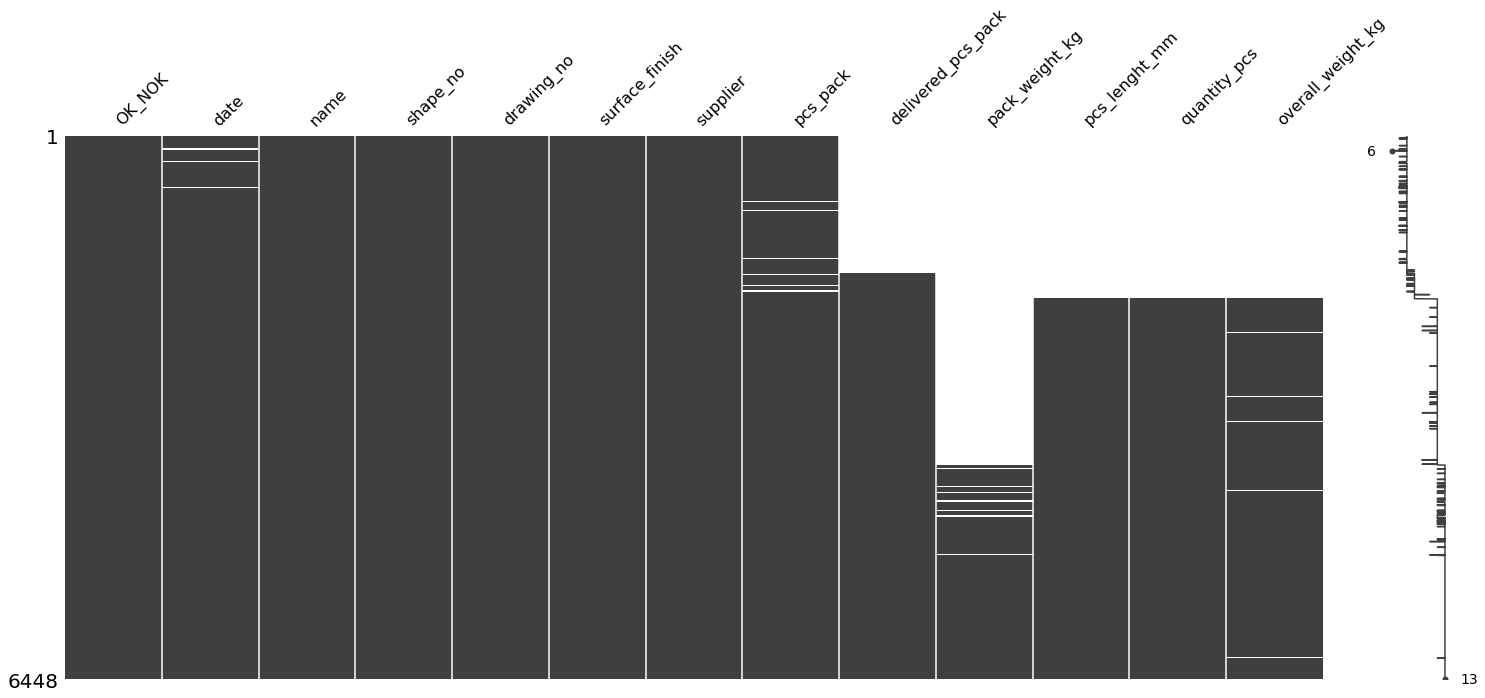

In [41]:
missingno.matrix(df)

<AxesSubplot:>

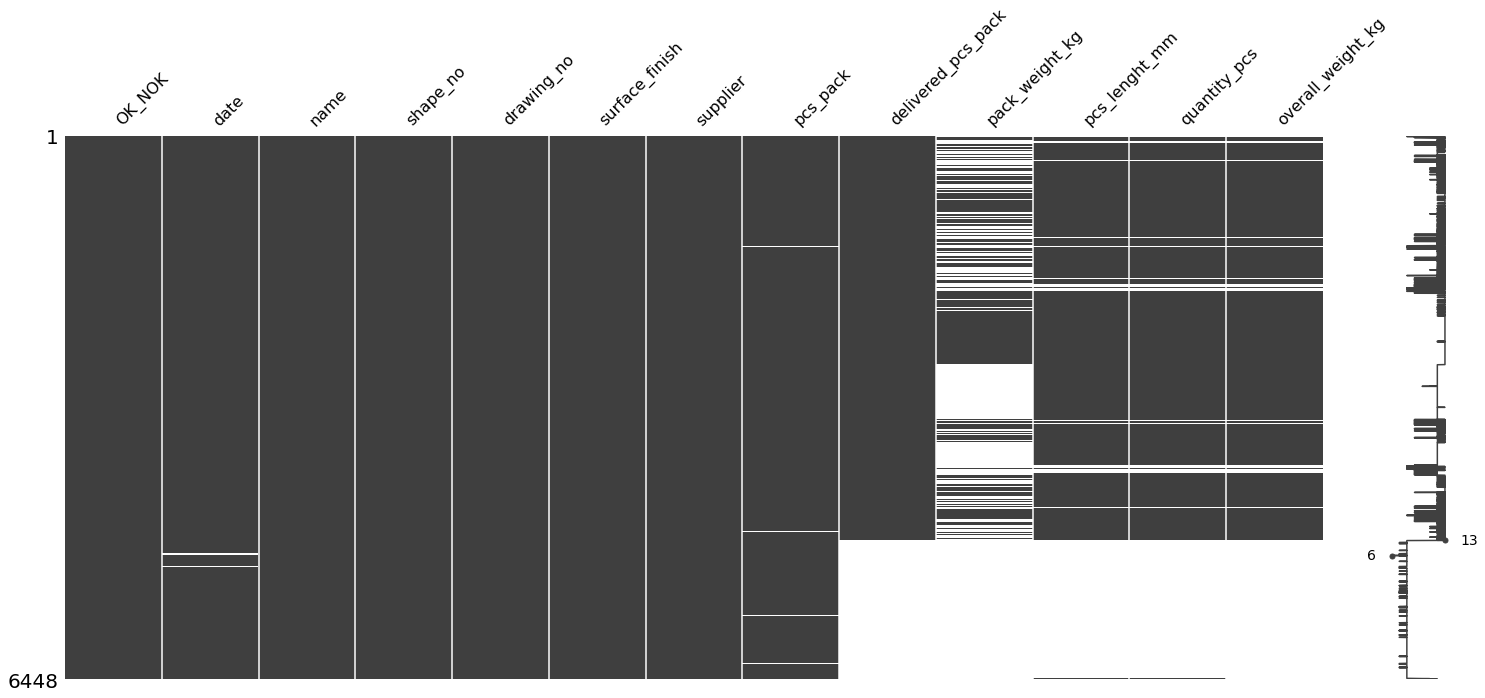

In [42]:
sorted_delivered_pcs_pack = df.sort_values('delivered_pcs_pack')
missingno.matrix(sorted_delivered_pcs_pack)

### 2.6 Data distribution

Since the data is about the delivery of goods some products will be delivered more frequent than others. Let's find out which features make products unique and then check how the products are represented in the dataset by using seaborn count plot.

For choosing unique features we will group the data by name then by drawing number and color.

In [43]:
# filtering a list of unique deliveries.
vc_combo = df[['name','drawing_no', 'surface_finish']].apply(tuple, axis=1).value_counts()
vc_combo

(Vindemiatrix, DR5, color2)     270
(Sargas, DR1, color2)           250
(Lepus, DR0, color2)            237
(Vindemiatrix, DR10, color2)    234
(Sargas, DR20, color2)          205
                               ... 
(Alcyone, DR113, color1)          1
(Monoceros, DR112, color1)        1
(Pegasus2, DR169, color2)         1
(Mirach, DR170, color1)           1
(Delphinus, DR143, color3)        1
Length: 352, dtype: int64

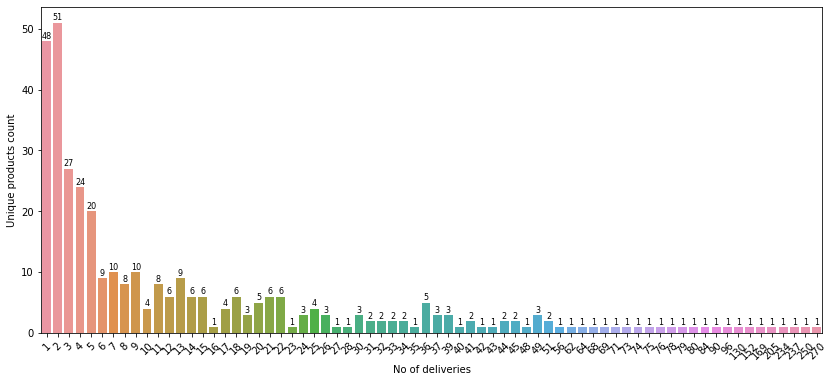

In [44]:
plt.figure(figsize=(14, 6))
ax = sns.countplot(data=df, x=vc_combo)
plt.xlabel('No of deliveries')
plt.ylabel('Unique products count')
plt.xticks(rotation=45);


for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

Here's an intriguing observation from our dataset: there's a significant cluster of unique deliveries happening less than 10 times. This discovery sparked some reflection. Why is this happening? It could be due to various factors, maybe it's the introduction of new products, the presence of low-sales volume items, sporadic deliveries from suppliers like cargo shipping, or perhaps it's a result of discontinued relationships with underperforming suppliers. Regardless, it's clear that relying on predictive modeling with such sparse data can lead to unreliable outcomes.

To tackle this challenge, I decided to filter out products with fewer than 5 deliveries. It's a strategic move aimed at strengthening the model's reliability by prioritizing more representative data points. Of course, validating this filtering criterion during model evaluation is essential to ensure it actually enhances predictive accuracy and generalizability.

Looking at the plot, it's evident that there are at least 150 unique products delivered less than 5 times. At this stage, attempting to predict outcomes for these products might not yield reliable results. It's all part of the journey of building a predictive model—facing obstacles head-on and finding creative solutions to ensure our model reflects the real world as accurately as poss.e.y.

As observed in the early CatBoost prediction, the dataset reveals a notable class imbalance, with Class 1 being approximately five times more represented than Class 0. This observation aligns with business realities, as an equal distribution of NOK (Not OK) deliveries would impede operational efficiency. Our conclusion was that the presence of close to 20% NOK deliveries indicates significant room for improvement in the delivery process. While the imbalance may vary over time due to quality improvement efforts, analyzing the features of NOK products across all years can help identify patterns and areas for enhancement. This approach can inform targeted interventions to address underlying issues and improve overall product quality and delivery efficiency.


In [45]:
ok_nok_vc = df['OK_NOK'].value_counts()
percentage_0 = ok_nok_vc[0] / ok_nok_vc.sum() * 100
percentage_1 = ok_nok_vc[1] / ok_nok_vc.sum() * 100

print(f"Percentage of class 0: {percentage_0:.2f}%")
print(f"Percentage of class 1: {percentage_1:.2f}%")

Percentage of class 0: 18.98%
Percentage of class 1: 81.02%


### 3. Data preprocesing

#### 3.1 Data cleaning - date column

In this section, we performed data cleaning on the 'date' column to prepare it for further analysis. 
We began by inspecting the column's values to identify the variety of formats present, 
which included datetime objects, strings, and NaN values. We then categorized the data types 
and investigated the presence of letters in the string values. 

Subsequently, we created a new column 'date_fmt' to store the cleaned datetime values. 
We converted the string values to datetime format using a consistent date format and addressed 
any remaining NaT (Not a Time) values by manually inspecting and correcting them.

Finally, we verified the results by checking the data types and non-null counts in the 'date_fmt' column. 
These actions ensure that the 'date' column is now suitable for use in subsequent analyses 
without compromising the integrity of the dataset.

In [46]:
df['date'].apply(type).nunique()

3

In [47]:
df['date'].apply(type).value_counts()

<class 'datetime.datetime'>    4621
<class 'str'>                  1782
<class 'float'>                  45
Name: date, dtype: int64

In [48]:
df.head(2)

,OK_NOK,date,name,shape_no,drawing_no,surface_finish,supplier,pcs_pack,delivered_pcs_pack,pack_weight_kg,pcs_lenght_mm,quantity_pcs,overall_weight_kg
0,0,"13,01,2017",Lepus,SH0,DR0,color2,SU0,40.00,NaN,NaN,NaN,NaN,NaN
1,0,"13,01,2017",Sargas,SH1,DR1,color2,SU0,40.00,NaN,NaN,NaN,NaN,NaN


In [49]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OK_NOK              6448 non-null   int64  
 1   date                6403 non-null   object 
 2   name                6448 non-null   object 
 3   shape_no            6448 non-null   object 
 4   drawing_no          6448 non-null   object 
 5   surface_finish      6448 non-null   object 
 6   supplier            6448 non-null   object 
 7   pcs_pack            6350 non-null   float64
 8   delivered_pcs_pack  4801 non-null   float64
 9   pack_weight_kg      2405 non-null   float64
 10  pcs_lenght_mm       4514 non-null   float64
 11  quantity_pcs        4513 non-null   float64
 12  overall_weight_kg   4488 non-null   float64
dtypes: float64(6), int64(1), object(6)
memory usage: 2.6 MB


**Comment**: Let's check last entry, and NaN values:

In [50]:
df.date.iloc[-1]

datetime.datetime(2022, 9, 13, 0, 0)

In [51]:
df.date.isnull().sum()

45

**Comment**: Now I will create new column to check if there are any strings present in date column:

In [52]:
df['is_str'] = df.date.apply(lambda x: True if isinstance(x, str) else False)

In [53]:
df['is_str'].value_counts()

False    4666
True     1782
Name: is_str, dtype: int64

**Comment**: Now let's see if those strings contain any letters.

In [54]:
df.insert(2, 'is_str', df.pop('is_str'))


In [55]:
letter_pattern = re.compile(r"[a-zA-Z]")

In [56]:
filter_letter_pattern = df.loc[df['is_str']==True, 'date'].apply(lambda x: True if letter_pattern.search(x) else False)

In [57]:
len(filter_letter_pattern[filter_letter_pattern].index)

54

**Comment**: Out of all elements from date column that are strings 54 contain letters, which isnt that bad considering 1,8k strings.
My approach is to focus on strings that are not letters and try to convert those in to proper datetime format.
I will create new column date_fmt and I will use it to perform all operations there without risking loosing any valid data.

In [58]:
df.loc[df['is_str']==True,'date_fmt'] = df.loc[df['is_str']==True,'date']

In [59]:
df.insert(2, 'date_fmt', df.pop('date_fmt'))

In [60]:
df['date_fmt'] = df.loc[df['is_str']==True,'date_fmt'].str.replace(',', '.').str.replace('/', '.')

In [61]:
df['date_fmt'] = pd.to_datetime(df['date_fmt'], format='%d.%m.%Y', errors='coerce')

In [62]:
df['date_fmt'] = df['date_fmt'].dt.strftime('%Y-%m-%d %H:%M:%S')

**Comment**: Now I will copy over from date column the data that are not strings and convert them to datetime.

In [63]:
df.loc[df['is_str']==False, 'date_fmt'] = pd.to_datetime(df.loc[df['is_str']==False, 'date'], format='%Y-%m-%d %H:%M:%S')

In [64]:
df['date_fmt'] = pd.to_datetime(df['date_fmt'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

**Comment**: After successfully converting the majority of the data to datetime format, the next step involves addressing the remaining NaT (Not a Time) values.

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   OK_NOK              6448 non-null   int64         
 1   date                6403 non-null   object        
 2   date_fmt            6345 non-null   datetime64[ns]
 3   is_str              6448 non-null   bool          
 4   name                6448 non-null   object        
 5   shape_no            6448 non-null   object        
 6   drawing_no          6448 non-null   object        
 7   surface_finish      6448 non-null   object        
 8   supplier            6448 non-null   object        
 9   pcs_pack            6350 non-null   float64       
 10  delivered_pcs_pack  4801 non-null   float64       
 11  pack_weight_kg      2405 non-null   float64       
 12  pcs_lenght_mm       4514 non-null   float64       
 13  quantity_pcs        4513 non-null   float64     

**Comment**: I've opted to manually inspect all remaining NaT (Not a Time) values to retrieve any salvageable data.

In [66]:
original_max_rows = pd.options.display.max_rows

# Temporarily set display options to show all rows
pd.options.display.max_rows = None

# Run the query
result = df.query('date_fmt.isnull()')
# result

In [67]:
df.loc[72, 'date_fmt'] = '2016.10.12'
df.loc[74, 'date_fmt'] = '2016.10.10'
df.loc[233, 'date_fmt'] = '2016.10.12'
df.loc[426, 'date_fmt'] = '2016.03.28'
df.loc[894, 'date_fmt'] = '2018.02.21'
df.loc[1532, 'date_fmt'] = '2018.09.12'
df.loc[1777, 'date_fmt'] = '2018.11.21'
df.loc[1908, 'date_fmt'] = '2018.12.12'

In [68]:
df['date_fmt'] = pd.to_datetime(df['date_fmt'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [69]:
pd.options.display.max_rows = original_max_rows

**Comment**: Now, it's time to address the remaining missing data. Given that this table is filled in chronological order and that most of the missing data have low indexes, we can infer that these inspections were likely conducted around 2016.

In [70]:
def random_date(year):
    starting_date = datetime(year, 1, 1)
    stopping_date = datetime(year, 12, 31)
    random_days = randint(0, (stopping_date - starting_date).days)
    return starting_date + timedelta(days=random_days)

In [71]:
df.loc[df['date_fmt'].isnull(), 'date_fmt'] = random_date(2016)

In [72]:
df['date_fmt'].isnull().sum()

0

In [73]:
df.drop(['date', 'is_str'],  axis=1, inplace=True)

**Comment**  I noticed that some dates are set for future occurrences. It seems like this might be because of using the drag-and-drop function in Excel. It looks like someone tried to copy the dates across cells, maintaining the day and month but accidentally changing the year in each cell.

In [74]:
sorted_date_fmt = df.date_fmt.sort_values(ascending=False)
sorted_date_fmt[sorted_date_fmt>'01.01.2023']
sorted_date_fmt_idx = sorted_date_fmt[sorted_date_fmt>'01.01.2023'].index
sorted_date_fmt_idx


Int64Index([1479, 1478, 1477, 1347, 1476, 1346, 1345, 1474, 1344], dtype='int64')

In [75]:
idx_to_change = df.loc[1340:1347].index

In [76]:
idx_to_change2 = df.loc[1470:1479].index

In [77]:
idx_to_change_combined = idx_to_change.append(idx_to_change2)

In [78]:
idx_to_change_combined

Int64Index([1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1470, 1471, 1472,
            1473, 1474, 1475, 1476, 1477, 1478, 1479],
           dtype='int64')

In [79]:
for idx in idx_to_change_combined:
    df.loc[idx, 'date_fmt'] = df.loc[idx, 'date_fmt'].replace(year=int(2018))

### 3.2 Data cleaning - rest of the columns
**Comment**: Fortunately, all string columns have been pre-processed during the encoding process, ensuring data uniformity. This encoding was implemented to render the products unrecognizable, thus complying with legal requirements.

In [80]:
df['name'].apply(type).nunique()

1

In [81]:
df['name'].apply(type).value_counts()

<class 'str'>    6448
Name: name, dtype: int64

In [82]:
df['name'] = df['name'].astype(str)

In [83]:
df['shape_no'].apply(type).nunique()

1

In [84]:
df['shape_no'] = df['shape_no'].astype(str)

In [85]:
df['drawing_no'].apply(type).nunique()

1

In [86]:
df['drawing_no'] = df['drawing_no'].astype(str)

In [87]:
df['surface_finish'].apply(type).nunique()

1

In [88]:
df['surface_finish'] = df['surface_finish'].astype(str)

In [89]:
df['supplier'].apply(type).nunique()

1

In [90]:
df['supplier'] = df['supplier'].astype(str)

**Comment**: "The 'quantity_pcs' column represents the volume of each delivery. Generally, quantities below 100 pieces per delivery may indicate special cases like prototype orders, overproduction, or underproduction, rather than standard delivery volumes which usually are much grater. It's crucial to exclude such instances from our model training to prevent bias or inaccuracies. Segregating and excluding these outliers ensures the reliability of our model for analyzing regular deliveries."

In [91]:
quantity_pcs_vc = df['quantity_pcs'] .value_counts()
quantity_pcs_vc
filtered_quantity_pcs_vc = quantity_pcs_vc[quantity_pcs_vc.index<100].sort_values(ascending=False)
row_index_vc = df[df['quantity_pcs'].isin(filtered_quantity_pcs_vc.index)].index
row_index_vc

Int64Index([1953, 1968, 2010, 2063, 2065, 2067, 2079, 2103, 2107, 2123,
            ...
            6362, 6365, 6381, 6383, 6388, 6407, 6422, 6424, 6427, 6434],
           dtype='int64', length=299)

In [92]:
df.drop(row_index_vc, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [93]:
df.loc[4626,'pack_weight_kg'] = float(36.00)

In [94]:
df['pack_weight_kg'] = df['pack_weight_kg'].replace(0, np.nan)

### 4. Filling missing Values

Finding missing values within the dataset by utilizing columns that characterize each record as unique, such as 'drawing_no', 'surface_finish', and 'name'. 

Columns with missing values:

- pack_weight_kg
- pcs_lenght_mm
- delivered_pcs_pack
- pcs_pack
- quantity_pcs

The function `find_missing_vals()` iterates through each index with missing values and searches for matching rows based on the specified unique columns. If matching rows are found, it retrieves corresponding data from the non-null values of the target column, using operations like taking the median or grabbing the first non-null value. This approach ensures that missing values are filled with meaningful data, contributing to the integrity of the dataset.


Create a list of indices for each row except for overall_weight_kg which is going to be calculated from data.

In [95]:
pack_weight_null_list = list(df[df['pack_weight_kg'].isnull()].index)
pcs_lenght_mm_null_list = list(df[df['pcs_lenght_mm'].isnull()].index)
delivered_pcs_pack_null_list = list(df[df['delivered_pcs_pack'].isnull()].index)
pcs_pack_null_list = list(df[df['pcs_pack'].isnull()].index)
quantity_pcs_null_list = list(df[df['quantity_pcs'].isnull()].index)

In [96]:
def find_missing_vals(df, column_with_nan, idx_null_list, unique_col1='drawing_no', unique_col2='surface_finish', unique_col3='name', grab='iloc[0]'):
    grab_operations = {
        'iloc[0]': lambda series: series.iloc[0],
        'median': lambda series: series.median(),
        # Add more operations as needed
    }
    for idx in idx_null_list:

        matching_rows = df[(df[unique_col1] == df.loc[idx, unique_col1]) &
                   (df[unique_col2] == df.loc[idx, unique_col2]) &
                   (df[unique_col3] == df.loc[idx, unique_col3]) &
                   (df[column_with_nan].notnull())]

        if not matching_rows.empty:
            corresponding_data = grab_operations[grab](matching_rows[column_with_nan])
            df.loc[idx, column_with_nan] = corresponding_data
        else:
            df.loc[idx, column_with_nan] = np.nan
            

Finding missing values within dataset by using  columns that characterize each record as unique.

    * pack_weight_kg
    * pcs_lenght_mm
    * delivered_pcs_pack
    * pcs_pck
    * quantity_pcs

In [97]:
find_missing_vals(df, 'pack_weight_kg', pack_weight_null_list)

In [98]:
find_missing_vals(df, 'pcs_lenght_mm', pcs_lenght_mm_null_list)

In [99]:
find_missing_vals(df, 'delivered_pcs_pack', delivered_pcs_pack_null_list)

In [100]:
find_missing_vals(df, 'pcs_pack', pcs_pack_null_list)

In [101]:
find_missing_vals(df, 'quantity_pcs', quantity_pcs_null_list, grab='median')

In [102]:
df['date_fmt'] = pd.to_datetime(df['date_fmt'])

In [103]:
df.isnull().sum().sort_values(ascending=False)

overall_weight_kg     1948
pack_weight_kg         340
pcs_lenght_mm          168
quantity_pcs           168
pcs_pack                97
delivered_pcs_pack      76
OK_NOK                   0
date_fmt                 0
name                     0
shape_no                 0
drawing_no               0
surface_finish           0
supplier                 0
dtype: int64

The "find_missing_vals()" function has successfully filled in the majority of the missing data. Now, it's time to address the remaining NaN's.

**pcs_pck**

Filling missing values in the 'pcs_pack' column by identifying matching rows based on the 'delivered_pcs_pack' column, where 'delivered_pcs_pack' is not null. If matching rows are found, the missing value in 'pcs_pack' is replaced with the value from the first matching row. If no matching rows are found, the missing value is set to NaN. Finally, the mode of the 'pcs_pack' column is used to fill any remaining missing values. This process ensures that missing values in 'pcs_pack' are replaced with appropriate values, enhancing the completeness of the dataset.

In [104]:
pcs_pack_null_list = list(df[df['pcs_pack'].isnull()].index)
len(pcs_pack_null_list)

97

In [105]:
for idx in pcs_pack_null_list:

    matching_rows = df['pcs_pack'][
                                  (df['delivered_pcs_pack'] == df.loc[idx, 'delivered_pcs_pack']) &
                                  (df['delivered_pcs_pack'].notnull())]
    if not matching_rows.empty:
        df.loc[idx, 'pcs_pack'] = matching_rows.iloc[0]
    else:
            df.loc[idx, 'pcs_pack'] = np.nan

In [106]:
pcs_pack_mode = df['pcs_pack'].mode()
df['pcs_pack'] = df['pcs_pack'].fillna(pcs_pack_mode[0])

**delivered_pcs_pack**

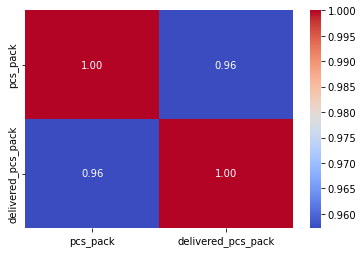

In [107]:
sns.heatmap(df[['pcs_pack', 'delivered_pcs_pack']].corr(),annot=True, fmt='.2f',cmap='coolwarm')
plt.show()

It's observed that 'pcs_pck' and 'delivered_pcs_pack' are nearly identical, suggesting redundancy. I wanted to remove delivered_pcs_pack from the dataset (had more NaN's) but our erly CatBoost algorithm choose this feature as the most important. Even if one of these features is probably redundant it would be interesting to see where are they in terms of feature_imporatances_ after pre-processing.


Since we are'nt dropping the delivered_pcs_pack at least for now we need to pre-process this features and fill the Nan's

In [108]:
delivered_pcs_pack_null_list = list(df[df['delivered_pcs_pack'].isnull()].index)
len(delivered_pcs_pack_null_list)

76

In [109]:
for idx in delivered_pcs_pack_null_list:

    matching_rows = df['delivered_pcs_pack'][
                                  (df['pcs_pack'] == df.loc[idx, 'pcs_pack']) &
                                  (df['pcs_pack'].notnull())]
    if not matching_rows.empty:
        df.loc[idx, 'delivered_pcs_pack'] = matching_rows.iloc[0]
    else:
            df.loc[idx, 'delivered_pcs_pack'] = np.nan

In [110]:
delivered_pcs_pack_mode = df['delivered_pcs_pack'].mode()
df['delivered_pcs_pack'] = df['delivered_pcs_pack'].fillna(delivered_pcs_pack_mode[0])

In [111]:
df['delivered_pcs_pack'].isnull().sum()

0

**pack_weight_kg**

In [112]:
len(df[(df['pack_weight_kg'].isnull())])

340

In [113]:
pack_weight_kg_median = df['pack_weight_kg'].median()
pack_weight_kg_median

27.2

After filtering the DataFrame `df`, we can still find sufficient data to compute the missing values for the 'pack_weight_kg' column. Specifically, there are 67 records where the necessary information is available. We will calculate these values by dividing the 'overall_weight_kg' by the 'quantity_pcs' and then multiplying the result by 'delivered_pcs_pack'.

In [114]:
len(df[(df['pack_weight_kg'].isnull()) & (df['overall_weight_kg'].notnull()) &  (df['overall_weight_kg'] != 0) & (df['pcs_pack'].notnull())])

67

In [115]:
pack_weight_null_list = list(df[df['pack_weight_kg'].isnull()].index)


In [116]:
# Iterate over the indices of rows with missing values in 'overal_weight_kg'
for idx in pack_weight_null_list:
    # Extract necessary values from the DataFrame
    quantity_pcs = df.loc[idx, 'quantity_pcs']
    overall_weight_kg = df.loc[idx, 'overall_weight_kg']
    pcs_pack = df.loc[idx,'pcs_pack']
    
    # Calculate corresponding overall weight
    if overall_weight_kg != 0 and pcs_pack != 0 and quantity_pcs != 0:
        compute_pack_weight = (overall_weight_kg / quantity_pcs) * pcs_pack
        # Assign the calculated overall weight to the corresponding row in 'overal_weight_kg' column
        df.loc[idx, 'pack_weight_kg'] = compute_pack_weight

In [117]:
len(df[(df['pack_weight_kg'].isnull())])

273

This is as far as i can go to find missing values, the rest would have to be inputed by the median, but instead of using median on all values I will input the median value for each indyvidual "delivered_pck' column.

In [118]:
for idx in pack_weight_null_list:
    matching_rows = df['pack_weight_kg'][
                                  (df['delivered_pcs_pack'] == df.loc[idx, 'delivered_pcs_pack']) &
                                  (df['delivered_pcs_pack'].notnull())]  
    if not matching_rows.empty:
        df.loc[idx, 'pack_weight_kg'] = matching_rows.median()       
    else:
            df.loc[idx, 'pack_weight_kg'] = np.nan           

In [119]:
print(len(df[(df['pack_weight_kg'].isnull())]))
len(df[(df['pack_weight_kg']==0)])

0


0

**pcs_lenght_mm**

In [120]:
pcs_lenght_mm_mode = df['pcs_lenght_mm'].mode()[0]
df['pcs_lenght_mm'] = df['pcs_lenght_mm'].fillna(pcs_lenght_mm_mode)

In [121]:
df['pcs_lenght_mm'].isnull().sum()

0

**quantity_pcs**

In [122]:
quantity_pcs_median = int(df['quantity_pcs'].median())
df['quantity_pcs'] = df['quantity_pcs'].fillna(quantity_pcs_median)
df['quantity_pcs'].isnull().sum()

0

**overall_weight_kg**

The 'overall_weight_kg' column contains NaNs and zeroes, which shouldn't be filled with median values. Doing so could potentially result in misleading information since the overall weight primarily depends on the quantity and weight of individual packets. Fortunately, we have both of these features available. Instead of using a median, let's devise a logic to recalculate the weight for each example based on its individual packet quantities and weights.

In [123]:
overall_weight_kg_na_idx = df.loc[(df['overall_weight_kg'].isnull()) | (df['overall_weight_kg'] == 0)].index

In [124]:
# Iterate over the indices of rows with missing values in 'overal_weight_kg'
for idx in overall_weight_kg_na_idx:
    # Extract necessary values from the DataFrame
    quantity_pcs = df.loc[idx, 'quantity_pcs']
    pcs_pck = df.loc[idx, 'pcs_pack']
    pack_weight_kg = df.loc[idx,'pack_weight_kg']
    
    # Calculate corresponding overall weight
    corresponding_overal_weight = (quantity_pcs / pcs_pck) * pack_weight_kg
    
    # Assign the calculated overall weight to the corresponding row in 'overal_weight_kg' column
    df.loc[idx, 'overall_weight_kg'] = corresponding_overal_weight

Additionaly its better to change units from millimeters and kilograms to meters and tonnes.

In [125]:
df.head(2)

,OK_NOK,date_fmt,name,shape_no,drawing_no,surface_finish,supplier,pcs_pack,delivered_pcs_pack,pack_weight_kg,pcs_lenght_mm,quantity_pcs,overall_weight_kg
0,0,2017-01-13,Lepus,SH0,DR0,color2,SU0,40.00,50.00,23.70,4050.00,1070.00,633.98
1,0,2017-01-13,Sargas,SH1,DR1,color2,SU0,40.00,40.00,39.70,4150.00,790.00,784.08


In [126]:
df['pcs_lenght_mm'] = df['pcs_lenght_mm'] / 1000
df['overall_weight_kg'] = df['overall_weight_kg'] * 1000
df['pack_weight_kg '] = df['pack_weight_kg'] * 1000

In [127]:
df = df.rename(columns={'pcs_lenght_mm' : 'pcs_length_m', 'overall_weight_kg': 'overall_weight_t', 'pack_weight_kg ': 'pack_weight_t'})


In [128]:
df.isnull().sum().sort_values(ascending=False)

OK_NOK                0
date_fmt              0
name                  0
shape_no              0
drawing_no            0
surface_finish        0
supplier              0
pcs_pack              0
delivered_pcs_pack    0
pack_weight_kg        0
pcs_length_m          0
quantity_pcs          0
overall_weight_t      0
pack_weight_t         0
dtype: int64

The Nan values has been handeld therefore, I opted to store the result in a new modified DataFrame (modified_df).

In [129]:
df.to_csv('modified_dataframe.csv', index=False)

In [130]:
dtype = {'date_fmt': 'datetime64[ns]'}
modified_df = pd.read_csv('modified_dataframe.csv', parse_dates=['date_fmt'])

### 5 Outlier detection and removal

Outliers are defined as observations that deviate significantly from the rest of the data, either by being exceptionally high or low in value. Even if those outliers are not errors but indeed natural occurrences, like the sole delivery of aluminum LED profiles that weighed nearly 2 tons where the median is around 600 kg. Building a reliable predictive model means using reliable generalized data, typically centered around the mean. One common approach is to identify outliers based on statistical measures such as the interquartile range (IQR) or a specified number of standard deviations from the mean, and then remove them from the dataset. In this section we will use IQR called also Tukey method.

In [131]:
def detect_outliers(df, n, features):
    outlier_indices=[]
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.75 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n)
    return (multiple_outliers)

outliers_to_drop = detect_outliers(modified_df, 0, ['pack_weight_t','quantity_pcs', 'overall_weight_t'])
print("We will drop these {} indices: ".format(len(outliers_to_drop)), outliers_to_drop)


We will drop these 183 indices:  [336, 340, 919, 1233, 1234, 1275, 1612, 1689, 1827, 1830, 1831, 2230, 2996, 3800, 4437, 4464, 4756, 4757, 4758, 4887, 5011, 5013, 5014, 5016, 5020, 5021, 5022, 5082, 5148, 5500, 5501, 5552, 5863, 5866, 5867, 5868, 5869, 5983, 1643, 1653, 2007, 2024, 2025, 2036, 2130, 2136, 2138, 2181, 2188, 2270, 2274, 2335, 2360, 2364, 2365, 2431, 2505, 2709, 2772, 2845, 2893, 2908, 3067, 3188, 3241, 3252, 3280, 3282, 3383, 3387, 3389, 3422, 3493, 3571, 3582, 3654, 3690, 3697, 3818, 3939, 4118, 4232, 4388, 4445, 4804, 4805, 4915, 4918, 4944, 5023, 5161, 5162, 5403, 5430, 5472, 5762, 5780, 5825, 5864, 5872, 5879, 54, 75, 85, 105, 106, 107, 228, 240, 241, 264, 288, 294, 341, 344, 345, 366, 367, 403, 405, 491, 492, 496, 497, 498, 510, 586, 595, 596, 613, 685, 686, 732, 735, 749, 758, 854, 855, 856, 857, 858, 1084, 1090, 1091, 1175, 1178, 1183, 1184, 1187, 1276, 1277, 1300, 1303, 1340, 1343, 1347, 1450, 1515, 1596, 1601, 1618, 1619, 1621, 1622, 1623, 1645, 1779, 1794, 1869

In [132]:
df_outliers_to_drop = modified_df.loc[outliers_to_drop]

In [133]:
print('Before droping training set has {} rows'.format(len(modified_df)))
modified_df = modified_df.drop(outliers_to_drop, axis=0).reset_index(drop=True)
print(f'After droping training set has {len(modified_df)} rows')

Before droping training set has 6149 rows
After droping training set has 5966 rows


### 6 Feature analysis
     6.1 Numerical values:
     * "pcs_pck",
     * "pcs_lenght_mm",
     * "overall_weight_t",
     * "quantity_pcs",
     * "pack_weight_t",

In feature analysis, we explore various aspects of the features, including their distribution, relationships with other features, importance for predicting the target variable, and potential for transformation or engineering. By delving into the details of the features, we can uncover patterns, identify correlations, and extract valuable information that drives decision-making and problem-solving.

Before we begin to analise the dataset let's remove those unique deliveries that occured less than 5 times.

In [134]:
# Group by the three columns and count occurrences
combo_counts = modified_df.groupby(['drawing_no', 'surface_finish', 'name']).size()

# Filter combinations with counts less than 5
filtered_combos = combo_counts[combo_counts < 5].index

# Filter the DataFrame based on the filtered combinations
modified_df = modified_df[~modified_df[['drawing_no', 'surface_finish', 'name']].apply(tuple, axis=1).isin(filtered_combos)]


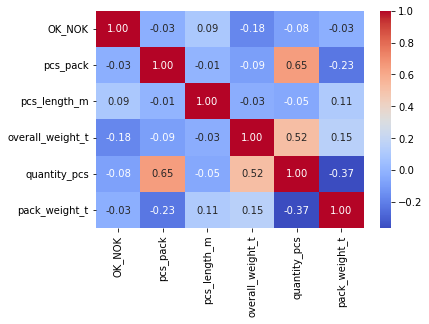

In [135]:
g = sns.heatmap(modified_df[["OK_NOK","pcs_pack", "pcs_length_m", "overall_weight_t", "quantity_pcs","pack_weight_t"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

While it appears that no feature exhibits a significant linear correlation with the target feature, it's important to note that this doesn't render the features useless. Subgroups within these features may still exhibit correlations with survival rates. To ascertain this, a detailed exploration of these features is necessary.

**delivered_pcs_pack**

The column "delivered_pcs_pack" in our dataset provides insight into the actual number of pieces packed and delivered by suppliers, distinct from the pcs_pack column planned for optimized packing quantities. The fact that it's chosen as an important feature during splits indicates that the algorithm finds it helpful for spliting the data effectively.

In [136]:
delivered_count = modified_df['delivered_pcs_pack'].value_counts()
delivered_count

40.00     2152
20.00     1292
50.00      752
100.00     500
60.00      319
30.00      182
10.00      164
24.00       81
25.00       56
8.00        51
12.00       26
15.00       22
28.00       15
18.00       12
32.00       11
42.00        9
80.00        6
21.00        3
48.00        2
120.00       1
Name: delivered_pcs_pack, dtype: int64

In [137]:
modified_df[['delivered_pcs_pack', 'OK_NOK']].groupby('delivered_pcs_pack').mean().sort_values('OK_NOK', ascending=False).reset_index()

,delivered_pcs_pack,OK_NOK
0,120.00,1.00
1,32.00,1.00
2,21.00,1.00
3,28.00,1.00
4,10.00,0.96
5,18.00,0.92
6,60.00,0.91
7,20.00,0.88
8,40.00,0.85
9,24.00,0.80


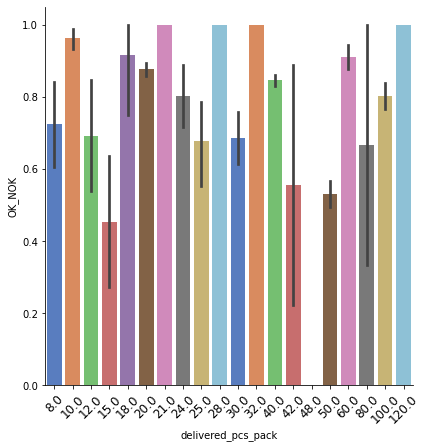

In [138]:
delivered_pcs_pack_plot = sns.catplot(x='delivered_pcs_pack', y='OK_NOK', data=modified_df, kind="bar", height=6, palette="muted")
delivered_pcs_pack_plot.set_xticklabels(rotation=45, fontsize=12)
plt.show()

#### Success rate (OK_NOK) with normilized delivery counts
New feature ['mean_OK_NOK_*_normalized_count'] will help identify the packing options that perform best when considering both the success rate and how often they were used. This can provide a more balanced view of which packaging option is truly the best.

In [139]:
grouped_delivered = modified_df[['delivered_pcs_pack', 'OK_NOK']].groupby('delivered_pcs_pack', as_index=False).agg(
mean_OK_NOK=('OK_NOK', 'mean'),
delivered_pcs_pack_count=('delivered_pcs_pack', 'count')
)

total_count = grouped_delivered['delivered_pcs_pack'].sum()
grouped_delivered['normalized_count'] = grouped_delivered['delivered_pcs_pack_count'] / total_count

grouped_delivered['mean_OK_NOK_*_normalized_count'] = grouped_delivered['mean_OK_NOK'] * grouped_delivered['normalized_count'] * 100
grouped_delivered

,delivered_pcs_pack,mean_OK_NOK,delivered_pcs_pack_count,normalized_count,mean_OK_NOK_*_normalized_count
0,8.00,0.73,51,0.07,4.73
1,10.00,0.96,164,0.21,20.18
2,12.00,0.69,26,0.03,2.30
3,15.00,0.45,22,0.03,1.28
4,18.00,0.92,12,0.02,1.40
5,20.00,0.88,1292,1.65,144.83
6,21.00,1.00,3,0.00,0.38
7,24.00,0.80,81,0.10,8.30
8,25.00,0.68,56,0.07,4.85
9,28.00,1.00,15,0.02,1.92


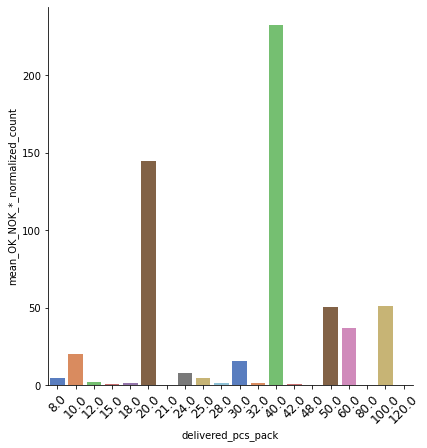

In [140]:
delivered_pcs_pack_plot = sns.catplot(x='delivered_pcs_pack', y='mean_OK_NOK_*_normalized_count', data=grouped_delivered.reset_index(), kind="bar", height=6, palette="muted")
delivered_pcs_pack_plot.set_xticklabels(rotation=45, fontsize=12)
plt.show()

**pcs_pck**

The "pcs_pack" column in our dataset signifies the planned or optimized packing quantities intended for delivery by suppliers. Unlike the "delivered_pcs_pack" column, which reflects the actual number of pieces packed and delivered, "pcs_pack" represents the predetermined targets for packing optimization purposes. While both columns share a common focus on packing quantities, "pcs_pack" specifically denotes the idealized quantities set for optimization strategies. Understanding the role of "pcs_pack" alongside its counterpart "delivered_pcs_pack" provides valuable insights into the planned versus actual packing dynamics within the supply chain context.

In [141]:
modified_df['pcs_pack'].value_counts()

40.00     2860
20.00     1609
100.00     517
60.00      338
10.00      264
25.00       35
50.00       28
80.00        5
Name: pcs_pack, dtype: int64

In [142]:
modified_df[['pcs_pack', 'OK_NOK']].groupby('pcs_pack', as_index=False).mean().sort_values('OK_NOK', ascending=False)

,pcs_pack,OK_NOK
4,50.00,1.00
0,10.00,0.85
1,20.00,0.85
5,60.00,0.85
7,100.00,0.81
2,25.00,0.80
3,40.00,0.77
6,80.00,0.60


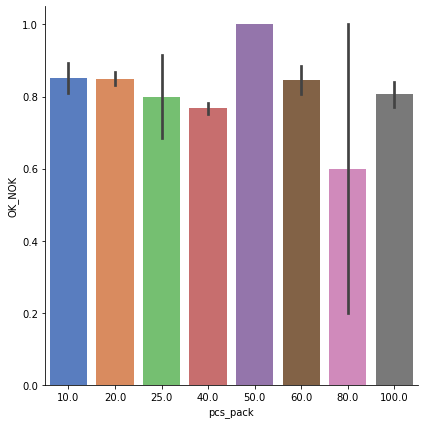

In [143]:
sns.catplot(x='pcs_pack', y='OK_NOK', data=modified_df, kind="bar", height=6, palette="muted")
plt.show()

Notably, analysis indicates that deliveries with profiles packed in quantities of 10,20 and 60 pieces exhibit the most favorable mean of 'OK/NOK', as evidenced by respectivly 264, 1609 and 338 deliveries. I deliberatly omited the result of 50pcs because it regerded one sample.
We are adding pcs_pck_bin, and change the feature into categorical most off all because although numeric in nature 80 doesn't have the meaning important as twice 40. This makes the feature discrete.

In [144]:
modified_df['pcs_pack_bin'] = modified_df['pcs_pack'].astype('category')

In [145]:
modified_df.drop('pcs_pack', axis=1, inplace=True)
modified_df.reset_index(drop=True, inplace=True)

**pcs_lenght_m**

From distribiution plot we can see that pcs_lenght_m column has 2 dominant values and therefore is more categorical than numerical feature.
After checking its value_count we going to create a descrete feature pcs_lenght_m_bin.

In [146]:
sns.displot(data=modified_df, x='pcs_lenght_m', kind='hist', label='Skewness: %.2f'%(modified_df['pcs_lenght_m'].skew()))
plt.legend(loc='best')
plt.show()

KeyError: 'pcs_lenght_m'

In [ ]:
pcs_lenght_m_vc = modified_df['pcs_lenght_m'].value_counts()
filterd_pcs_lenght_m_vc = pcs_lenght_m_vc[pcs_lenght_m_vc<1000]
pcs_lenght_m_vc

In [ ]:
 modified_df['pcs_lenght_m_bin'] =  modified_df['pcs_lenght_m'].apply(lambda x: 'Other_lenght' if x in filterd_pcs_lenght_m_vc else str(x))

In [ ]:
 modified_df['pcs_lenght_m_bin'].value_counts()

In [ ]:
 modified_df[['pcs_lenght_m_bin', 'OK_NOK']].groupby('pcs_lenght_m_bin', as_index=False).mean().sort_values(by='OK_NOK',ascending=False)

In [ ]:
sns.catplot(x='pcs_lenght_m_bin', y='OK_NOK', data=modified_df, kind="bar", height=6, palette="muted")
plt.show()

In [ ]:
modified_df.drop('pcs_lenght_m', axis=1, inplace=True)
modified_df.reset_index(drop=True, inplace=True)

It's interesting to note that the length category 4.15 has the least amount of "Not OK" (NOK) instances, followed by 4.05. Additionally, when all other lengths are grouped together into the 'Other_length' category, there's a noticeable decrease in the mean of "OK" instances, suggesting a potential pattern or relationship between length categories and the outcome.

This observation indicates that the length of the items packed might have an impact on the quality or outcome of the deliveries. It could be worthwhile to further investigate this relationship and explore potential reasons behind it. Perhaps certain lengths are more conducive to efficient packing or have fewer defects during manufacturing, leading to better outcome While the 'Other_length' category has a smaller sample size, it may still be valuable to explore its relationship with outcomes, especially if there are practical implications or potential insights that can be gained from understanding this relationship.s.

**overall_weight_t**

Creating overall_weight_t_bin

In [ ]:
weight_vc = modified_df['overall_weight_t'].value_counts()
weight_vc

In [ ]:
sns.displot(data=modified_df, x='overall_weight_t', kind='hist', label='Skewness: %.2f'%(modified_df['overall_weight_t'].skew()))
plt.legend(loc='best')
plt.show()

Next we add bins feature

In [ ]:
modified_df['overall_weight_t_bin'] = pd.cut(modified_df['overall_weight_t'], bins=5)

In [ ]:
modified_df[['overall_weight_t_bin', 'OK_NOK']].groupby('overall_weight_t_bin').mean().sort_values(by='OK_NOK', ascending=False)

In [ ]:
sns.catplot(x='overall_weight_t_bin', y='OK_NOK', data=modified_df, kind="bar", height=6, palette="muted")
plt.show()

In [ ]:
modified_df.drop('overall_weight_t', axis=1, inplace=True)
modified_df.reset_index(drop=True, inplace=True)

The insight gained from analyzing the 'overall_weight_t_bin' feature is quite interesting if not intriguing. The data indicates a clear trend: as the overall weight of the delivery increases, the mean of "OK/NOK" decreases. This suggests a negative linear correlation between the overall weight of the profile delivery and the quality outcome.

This observation implies that deliveries with smaller weights tend to have higher proportions of "OK" outcomes compared to deliveries with heavier weights. There could be several reasons behind this correlation. For example, lighter deliveries might undergo less stress during transportation, reducing the likelihood of damage or defects. Alternatively, it could be related to the packaging or handling processes, where lighter deliveries are easier to manage and less prone to mishandling.

Understanding this correlation can have practical implications for optimizing packaging strategies, transportation methods, and quality control measures. It may also help identify areas for improvement in handling heavier deliveries to ensure better quality outcomes.

**quantity_pcs**

Creating quantity_pcs_bin

In [ ]:
modified_df['quantity_pcs'].value_counts().sort_values(ascending=False)

In [ ]:
sns.displot(data=modified_df, x='quantity_pcs', kind='hist', label='Skewness: %.2f'%(modified_df['quantity_pcs'].skew()))
plt.legend(loc='best')
plt.show()

In [ ]:
modified_df['quantity_pcs_bin'] = pd.cut(modified_df['quantity_pcs'], bins=5)

In [ ]:
modified_df[['quantity_pcs_bin', 'OK_NOK']].groupby('quantity_pcs_bin').mean().sort_values(by='OK_NOK', ascending=False)

Quantity is better represented as categorical feature.

In [ ]:
quantity_bin_plot = sns.catplot(x='quantity_pcs_bin', y='OK_NOK', data=modified_df, kind="bar", height=6, palette="muted")
quantity_bin_plot.set_xticklabels(rotation=45, fontsize=8)
plt.show()

In [ ]:
modified_df.drop('quantity_pcs', axis=1, inplace=True)
modified_df.reset_index(drop=True, inplace=True)

The observation from the analysis of 'quantity_pcs_bin' and its corresponding mean of "OK/NOK" values indeed presents an intriguing pattern. It appears that there is some level of correlation between the binned quantity of pieces in each delivery and the outcome, but it's not as straightforward as the correlation observed with the 'overall_weight_t_bin' feature.s.Tng the apparent contradiction between the lower weight and the second most quantity, it's important to remember that correlation does not imply causation. While it may seem contradictory at first glance, there could be various factors at play that contribute to this observed pattern.

For e cristics: Certain products might have a higher quantity of pieces but lower individual weights, leading to the observed correlation.

**pack_weight_kg**

In [ ]:
modified_df['pack_weight_kg'].value_counts().sort_values(ascending=False)

Add bin feature

In [ ]:
sns.displot(data=modified_df, x='pack_weight_kg', kind='hist', label='Skewness: %.2f'%(modified_df['pack_weight_kg'].skew()))
plt.legend(loc='best')
plt.show()

In [ ]:
modified_df['pack_weight_kg_bin'] = pd.cut(modified_df['pack_weight_kg'], bins=5)

In [ ]:
pack_weight_bin_vc = modified_df['pack_weight_kg_bin'].value_counts()
pack_weight_bin_vc

In [ ]:
modified_df[['pack_weight_kg_bin', 'OK_NOK']].groupby('pack_weight_kg_bin').mean().sort_values(by='OK_NOK', ascending=False)

In [ ]:
pack_weight_bin_plot = sns.catplot(x='pack_weight_kg_bin', y='OK_NOK', data=modified_df, kind="bar", height=6, palette="muted")
pack_weight_bin_plot.set_xticklabels(rotation=45, fontsize=8)
plt.show()

In [ ]:
modified_df.drop('pack_weight_kg_bin', axis=1, inplace=True)
modified_df.reset_index(drop=True, inplace=True)

The analysis of the 'pack_weight_kg_bin' feature and its corresponding mean of "OK/NOK" values indicates that the weight of the package does not have a significant impact on the outcome.

### 6.2 Categorical features
    *name
    *shape_no
    *drawing_no
    *surface_finish
    *supplier
    
    


**name**
It's interesting to see what impact on quality is derived from the name feature. Let's begin with value counts to have a distinctive statistic on how many deliveries each profile had.

In [ ]:
name_vc = modified_df['name'].value_counts()
name_vc

In [ ]:
name_prob_ok_nok = modified_df.groupby('name')['OK_NOK'].mean()
name_order = name_prob_ok_nok.sort_values().index

In [ ]:
modified_df[['name', 'OK_NOK']].groupby('name').mean().sort_values(by='OK_NOK', ascending=False)

In [ ]:
name_plot = sns.catplot(x='name', y='OK_NOK', data=modified_df, kind="bar", height=25, aspect=3, palette="muted", order=name_order, legend=False)
name_plot.set_xticklabels(rotation=45, fontsize=16)
plt.show()

It's evident that there's a significant correlation between the names of the deliveries and their corresponding quality inspection results. Names like "Adara," "Markab," "Circinus," and "Columba" consistently have high 'OK/NOK' values of 1.00, indicating a high rate of successful deliveries. On the other hand, names like "Fornax," "Pherkad," "Hercules2," and "Capella" have lower 'OK/NOK' values, suggesting a higher frequency of delivery issues.

The most notable observation is the name "Phact," which has never been associated with a successful delivery (OK = 0.00). This suggests a consistent quality issue specifically associated with deliveries linked to this name. Further investigation into the underlying reasons for this consistent failure could provide valuable insights into potential improvements in quality control processes or identifying specific areas for corrective actions.

**shape_no**
The 'shape_no' feature doesn't differentiate between suppliers or colors; rather, it describes the shape of each profile. By examining whether certain shapes are associated with higher or lower quality outcomes, we can potentially uncover patterns that may inform quality control strategies, production decisions, and R&D design decisions.

To begin this analysis, we can follow a similar approach to what was done witother categoricale' featusre. We'll group the data by 'shape_no' and calculate the mean 'OK/NOK' values for each shape. This will allow us to identify any trends or correlations between shape and quality outcomes.

In [ ]:
shape_no_vc = modified_df['shape_no'].value_counts()
# filtered_shape_no_vc_35 = shape_no_vc[shape_no_vc<=35]


In [ ]:
shape_no_prob_ok_nok = modified_df.groupby('shape_no')['OK_NOK'].mean()
shape_no_order = shape_no_prob_ok_nok.sort_values().index

In [ ]:
modified_df[['shape_no', 'OK_NOK']].groupby('shape_no').mean().sort_values(by='OK_NOK', ascending=False)

In [ ]:
shape_no_plot = sns.catplot(x='shape_no', y='OK_NOK', data=modified_df, kind="bar", height=26, aspect=3, palette="muted", order=shape_no_order, legend=False)
shape_no_plot.set_xticklabels(rotation=45, fontsize=38)
plt.show()

 Similar to the analysis conducted for names, these results offer valuable insights into the relationship between shape and quality.

Shapes such as 'SH77', 'SH68', 'SH64', 'SH103', and 'SH104' consistently exhibit high 'OK/NOK' values of 1.00, suggesting a high rate of successful deliveries. On the other hand, shapes like 'SH2' and 'SH85' have 'OK/NOK' values of 0.00, indicating that deliveries associated with these shapes have never been successful. Additionally, shapes such as 'SH63', 'SH57', and 'SH107' have intermediate 'OK/NOK' values around 0.60, indicating a moderate success rate with room for improvement.

These insights highlight the impact of shape on quality outcomes in the delivery process. Shapes associated with higher 'OK/NOK' values may indicate more robust designs or manufacturing processes, while shapes with lower values may suggest potential issues that need to be addressed, either in design, production, or quality control.



**drawing_no**

drawing_no feature is a number that comes from supplier drawings. 
This means that this feature combines the name and a shape with a specific supplier.

In [ ]:
drawing_no_vc = modified_df['drawing_no'].value_counts()
drawing_no_vc

In [ ]:
drawing_no_prob_ok_nok = modified_df.groupby('drawing_no')['OK_NOK'].mean()
drawing_no_order = drawing_no_prob_ok_nok.sort_values().index

In [ ]:
modified_df[['drawing_no', 'OK_NOK']].groupby('drawing_no').mean().sort_values(by='OK_NOK', ascending=False)

In [ ]:
drawing_no_order_plot = sns.catplot(x='drawing_no', y='OK_NOK', data=modified_df, kind="bar", height=26, aspect=3, palette="muted", order=drawing_no_order, legend=False)
drawing_no_order_plot.set_xticklabels(rotation=45, fontsize=38)
plt.show()

. Certain drawing numbers, such as 'DR167', 'DR80', 'DR146', 'DR145', and 'DR135', exhibit high 'OK/NOK' values of 1.00, indicating a high success rate in deliveries associated with these drawing numbers. On the other hand, drawing numbers like 'DR114', 'DR151', and 'DR156' have lower 'OK/NOK' values, with 'DR114' having a value of 0.00, indicating no successful deliveries associated with that drawing numbe 

By focusing efforts on analyzing and improving the quality of products associated with drawing numbers that exhibit lower 'OK/NOK' values, manufacturers can identify and address underlying issues, potentially leading to improvements in overall product quality and customer satisfaction.r.

**surface_finish**

The 'surface_finish' feature comprises three major categories, each representing different surface finishes applied to the products. The question arises: Is there any correlation between the 'OK/NOK' status of deliveries and the color associated with each surface finish? Will this correlation also be as insightful as the ones before?

In [ ]:
surface_finish_vc = modified_df['surface_finish'].value_counts()
surface_finish_vc

In [ ]:
modified_df = modified_df[modified_df['surface_finish'] != "BIAŁY"]

In [ ]:
modified_df[['surface_finish', 'OK_NOK']].groupby('surface_finish').mean().sort_values(by='OK_NOK', ascending=False)

In [ ]:
surface_finish_plot = sns.catplot(x='surface_finish', y='OK_NOK', data=modified_df, kind="bar", height=6, aspect=2, palette="muted")
surface_finish_plot.set_xticklabels(rotation=45, fontsize=8)
plt.show()

Well the results are least informative than expected. Overall, they suggest that there may be some correlation between the color of the surface finish and the 'OK/NOK' status of deliveries. However, further analysis, is needed possibly the value of that feature lies in combination with specific shape or drawing_no?

**supplier**

This one is self explanatory, and should give us some insight about what type of quality is to be expected from different suppliers. It's evident from the outset that there are seven suppliers, each with varying volumes of deliveries and types of profiles manufactured.


In [ ]:
supplier_vc = modified_df['supplier'].value_counts()
supplier_vc

In [ ]:
supplier_prob_ok_nok = modified_df.groupby('supplier')['OK_NOK'].mean()
supplier_order = supplier_prob_ok_nok.sort_values().index

In [ ]:
modified_df[['supplier', 'OK_NOK']].groupby('supplier').mean().sort_values(by='OK_NOK', ascending=False)

In [ ]:
supplier_plot = sns.catplot(x='supplier', y='OK_NOK', data=modified_df, kind="bar", height=6, aspect=2, palette="muted", order=supplier_order,)
supplier_plot.set_xticklabels(rotation=45, fontsize=8)
plt.show()

The results highlight varying performance among suppliers. While SU3 and SU4 boast a 100% OK delivery rate, it's important to note their low volume of deliveries, with only 10 and 12 respectively. As the proverb goes, 'The one that does nothing does not make mistakes.' Additionally, SU2, with 131 deliveries and an impressive score of 0.94, deserves recognition for its consistent performance. However, it's crucial to consider the significantly higher delivery volumes of veterans such as SU1 with 3871 deliveries and SU0 with 1597 deliveries. On the other hand, SU6's extremely low OK delivery rate of 0.17 suggests immediate consideration for exclusion based on these results.

**One hot encoding the features**

In [ ]:
modified_df = pd.get_dummies(modified_df, drop_first=True, columns=['quantity_pcs_bin'], prefix='QUANTITY')

In [ ]:
modified_df = pd.get_dummies(modified_df, drop_first=True, columns=['pcs_lenght_m_bin'], prefix='LEN')

In [ ]:
modified_df = pd.get_dummies(modified_df, drop_first=True, columns=['overall_weight_t_bin'], prefix='O_WEIGHT')

In [ ]:
x = ['name','shape_no','drawing_no','surface_finish','supplier']
modified_df = pd.get_dummies(modified_df, drop_first=True, columns=x)

In [ ]:
modified_df.head(1)

Converting the 'date_fmt' column in DataFrame 'to_modeling_df' to a numeric representation using the toordinal() function, converts a date to its corresponding Gregorian ordinal. This essentially assigns a unique integer to each date, with earlier dates having lower ordinal values and later dates having higher ordinal values.

In [ ]:
modified_df['date_numeric'] = modified_df['date_fmt'].apply(lambda x: x.toordinal())

With the results of the cross validation and 'classifier.feature_importances_' of tree-based classifiers, became evident that the dominant feature was 'date_numeric'. To investigate the possibility of data leakage, I performed a Pearson correlation matrix.

In [ ]:
g = sns.heatmap(modified_df[["OK_NOK", "date_numeric"]].corr(), annot=True, fmt=".2f", cmap="coolwarm")

While the linear correlation between the 'date_numeric' feature and 'OK_NOK' suggests improvements in supplier quality over time and reflects the success of the quality department, it also raises concerns about potential data leakage. This inadvertently includes information not available during prediction, compromising model integrity. To address this, we should exclude features like 'date_numeric' from training set to ensure predictions rely solely on relevant, future-available data.

In [ ]:
modified_df.to_csv('to_modeling_dataframe.csv', index=False)
dtype = {'date_fmt': 'datetime64[ns]'}
to_modeling_df = pd.read_csv('to_modeling_dataframe.csv', parse_dates=['date_fmt'])


In [ ]:
from sklearn.model_selection import train_test_split

X = to_modeling_df.drop(['date_fmt','OK_NOK','date_numeric'], axis=1)
y = to_modeling_df['OK_NOK']

X_train_initial, X_test, y_train_initial, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [ ]:
from sklearn.metrics import confusion_matrix, make_scorer
from catboost import CatBoostClassifier, Pool
import numpy as np

#Define custom scoring function
def new_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, np.round(y_pred)).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    negative_precision = tn / (tn + fn) if (tn + fn) > 0 else 0
    f1_negative = 2 * (specificity * negative_precision) / (specificity + negative_precision) if (specificity + negative_precision) > 0 else 0
    return specificity, negative_precision, f1_negative

#Train CatBoost model
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,
    class_weights = {0: 5, 1: 0.5},
    eval_metric='F1'
)

categorical_features = X.columns.tolist()

train_pool = Pool(data=X_train_initial, label=y_train_initial, cat_features=categorical_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features)

#Fit model
cat_model.fit(train_pool, eval_set=test_pool, verbose=False, plot=True)

#Evaluate model with custom metrics after training
y_pred = cat_model.predict(test_pool, prediction_type='Class')

specificity, negative_precision, f1_negative = new_score(y_test, y_pred)
print(f"Specificity: {specificity}, Negative Precision: {negative_precision}, F1 Negative: {f1_negative}")


Balancing a dataset is crucial, especially when dealing with imbalanced class distributions. While the RandomUnderSampler method is popular for this task, blindly removing samples from the majority class can lead to loss of valuable information. This is particularly problematic in scenarios like quality control of shipments, where every data point matters for accurate predictions.

Instead of resorting to random undersampling, a more sophisticated technique called SMOTE (Synthetic Minority Over-sampling Technique) can be employed. SMOTE generates synthetic samples for the minority class, effectively balancing the class distribution while preserving the dataset's information. This approach ensures that no valuable data points are lost, making it a preferable choice for handling imbalanced datasets performance.

from imblearn.over_sampling import SMOTE

#Applying SMOTE to the initial training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_initial, y_train_initial)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

target = y_train_initial
features = X_train_initial


#Define the under-sampling and over-sampling techniques
over_sampler = SMOTE(sampling_strategy='not majority')

#Create a pipeline to combine under-sampling and over-sampling
sampling_pipeline = Pipeline([
    ('over_sampling', over_sampler)
])

#Fit and transform the data using the sampling pipeline
X_resampled, y_resampled = sampling_pipeline.fit_resample(features, target)


resampled_df = pd.concat([y_train_resampled, X_train_resampled], axis = 1)

resampled_df

resampled_ok_nok_vc = resampled_df['OK_NOK'].value_counts()
print(resampled_ok_nok_vc)

total_samples = resampled_ok_nok_vc.sum()
percentage_0 = (resampled_ok_nok_vc[0] / total_samples) * 100
percentage_1 = (resampled_ok_nok_vc[1] / total_samples) * 100

print(f"Percentage of class 0: {percentage_0:.2f}%")
print(f"Percentage of class 1: {percentage_1:.2f}%")


### 7 Modeling

    * 7.1 Simple modeling
        * Cross validate models on entire data set
        * Evaluating cross validation results
        * Hyperparameter tuning for best models
        * Plot learning curves
        * Feature importance of the tree-based classifiers
        * Using chosen models with test set
        * Evaluating test set results
    * 7.2 Ensemble modeling
        * Combining models
    * 7.3 Prediction
        * Prediction on test set
        * Prediction on random low class delivery
        * Lower frequency class prediction(less then 50 deliveries)
    

**Spliting dataset**

### 7.1 Simple modeling
#### Cross validate models on whole dataset

I used 11 popular classifiers and evaluated their mean: accuracy, precision, recall, false positive rate, and Receiver Operating Characteristic (ROC) Area Under the Curve (AUC) of each of them by a stratified k-fold cross-validation procedure.

* SVC
* Decision Tree Classifier 
* AdaBoost 
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer perceptron (neural network)
* KNN
* Logistic regression
* Linear Discriminant Analysis
* Catboost


In [411]:
# Cross validate model with Kfold stratified cross val
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True)
random_state = 54

Cross validation on 11 models

In [147]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from catboost import CatBoostClassifier

from sklearn.model_selection import cross_validate

class_weights = {0: 5, 1: 0.5}

# Define the classifiers and scoring metrics

classifiers = [
    SVC(random_state=random_state, class_weight=class_weights),
    DecisionTreeClassifier(random_state=random_state, class_weight=class_weights),
    AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state, class_weight=class_weights), random_state=random_state),
    RandomForestClassifier(random_state=random_state, class_weight=class_weights),
    ExtraTreesClassifier(random_state=random_state, class_weight=class_weights),
    GradientBoostingClassifier(random_state=random_state),  # Class weights not directly supported, handle in training if needed
    MLPClassifier(random_state=random_state, class_weight=class_weights),  # If using recent versions
    KNeighborsClassifier(),
    LogisticRegression(random_state=random_state, class_weight=class_weights),
    LinearDiscriminantAnalysis(),
    CatBoostClassifier(random_state=random_state, class_weights=class_weights)  # CatBoost accepts class_weights
]

from sklearn.metrics import make_scorer

def new_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    negative_precison = tn / (tn + fn)
    f1_negative = 2 * (specificity*negative_precison) / (specificity + negative_precison)
    return specificity, negative_precison, f1_negative

# Create a scorer for specificity using make_scorer
specificity_scorer = make_scorer(lambda y_true, y_pred: new_score(y_true, y_pred)[0], greater_is_better=True)

# Create a scorer for negative precision using make_scorer
negative_precision_scorer = make_scorer(lambda y_true, y_pred: new_score(y_true, y_pred)[1], greater_is_better=True)

# Create a scorer for negative precision using make_scorer
f1_negative_scorer = make_scorer(lambda y_true, y_pred: new_score(y_true, y_pred)[2], greater_is_better=True)

# Add specificity to your scoring metrics dictionary
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'specificity': specificity_scorer,
    'negative_precison' : negative_precision_scorer,
    'f1_negative': f1_negative_scorer
}

# List to hold cross-validation results for each classifier

cv_results_resampled = []

for classifier in classifiers:
    cv_result_resampled = cross_validate(classifier, X_train_resampled, y=y_train_resampled, scoring=scoring_metrics, cv=kfold, n_jobs=-1)
    cv_results_resampled.append(cv_result_resampled)

NameError: name 'random_state' is not defined

The StarifiedKfold function created 5 folds for cross-validation. Each fold is represented by a pair of train and test indices, where the training indices indicate the data points used for training the model, and the test indices denote the data points used for evaluating the model's performance. These folds ensure that each data point is used for both training and testing, minimizing bias and providing a robust assessment of the model's generalization ability.


In [413]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Define the number of folds
kfold = StratifiedKFold(n_splits=5, shuffle=True)

# Initialize a list to store all fold indices
all_fold_indices = []

# Iterate over each fold
for fold_idx, (train_indices, test_indices) in enumerate(kfold.split(X_train_resampled, y_train_resampled)):
    fold_indices = {'Fold': fold_idx + 1, 'Train Indices': train_indices, 'Test Indices': test_indices}
    all_fold_indices.append(fold_indices)

# Convert the list to a DataFrame
fold_indices_df = pd.DataFrame(all_fold_indices)

# Print the DataFrame
print(fold_indices_df)



   Fold                                      Train Indices  \
0     1  [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 14, 15, 1...   
1     2  [1, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 17, 18,...   
2     3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14,...   
3     4  [0, 1, 2, 4, 5, 6, 7, 8, 9, 12, 13, 15, 16, 18...   
4     5  [0, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...   

                                        Test Indices  
0  [7, 8, 13, 23, 26, 34, 55, 62, 66, 67, 71, 82,...  
1  [0, 2, 6, 9, 15, 16, 19, 37, 46, 51, 54, 56, 5...  
2  [12, 20, 27, 30, 35, 42, 48, 49, 64, 70, 77, 1...  
3  [3, 10, 11, 14, 17, 21, 22, 24, 28, 29, 31, 38...  
4  [1, 4, 5, 18, 25, 32, 33, 36, 40, 41, 43, 45, ...  


We have obtained our cross-validation results, which typically come in a format of dictionaries. However, to visualize and analyze these results conveniently, we aim to convert them into a pandas DataFrame.


In [414]:
# Create a dictionary to hold the data
algorithms =["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis", "CatBoost"]

data_resampled = {}
data_std_resampled = {}

# Iterate over the algorithms and their corresponding results
for algorithm, result in zip(algorithms, cv_results_resampled):
    # Create a dictionary to hold the results for the current algorithm
    algorithm_results = {}
    algorithm_std = {}
    # Iterate over the metrics and their scores
    for metric, scores in result.items():
        # Add the metric and its mean score to the algorithm_results dictionary
        algorithm_results[metric] = scores.mean()
        algorithm_std[metric] = scores.std()
    # Add the algorithm and its results to the data dictionary
    data_resampled[algorithm] = algorithm_results
    data_std_resampled[algorithm] = algorithm_std

# Convert the data dictionary into a DataFrame
cv_res_df_resampled = pd.DataFrame(data_resampled).T
cv_std_df_resampled = pd.DataFrame(data_std_resampled).T

### Evaluating Training Set Results

When predicting NOK products (class 0), it's crucial to assess not only how many times we incorrectly predicted class 1 (false positives), but also how many times we wrongly predicted class 0 (false negatives). 

In this context, a key metric is specificity, also known as the true negative rate or negative recall. Specificity is calculated as:

$$ Specificity = \frac{True\ Negatives}{True\ Negatives + False\ Positives} $$

It measures the proportion of actual NOK (class 0) instances correctly identified by the model among all actual NOK instances.

For example:

- True Negatives (correctly predicted NOK samples) = 100
- False Positives (incorrectly predicted OK samples as NOK) = 25

$$ Specificity = \frac{100}{100 + 25} = 0.8 $$

In this example, the specificity would be 0.8, indicating that our model correctly identified 80% of all actual NOK (class 0) samples. This means that out of all the NOK samples, our model misclassified 20% as "OK" = the Positives which was false.

Therefore, specificity complements recall by providing information about the model's performance in correctly identifying the negative class. Both metrics together offer a more comprehensive understanding of the model's performance across different classes.



### Results
These results showcase the performance metrics for various machine learning models. The fit_time represents the time taken by each model to train on the dataset, while score_time indicates the time taken to predict labels for the test data. The remaining metrics denote the performance of each model in terms of accuracy, precision, recall, F1 score, ROC AUC score, specificity, negative precision, and F1 score for negative instances.

Across the evaluated models, RandomForest, ExtraTrees, and AdaBoost exhibit relatively high performance, achieving accuracy scores of around 0.85 and precision scores above 0.90. These models also demonstrate good recall and F1 scores, indicating their ability to correctly classify positive instances while maintaining a balance between precision and recall. MultipleLayerPerceptron and CatBoost also perform well, with accuracy scores around 0.85 and competitive precision and recall values. KNeighboors, GradientBoosting, LinearDiscriminantAnalysis, and LogisticRegression show slightly lower performance compared to the top-performing models, with accuracy scores. SVC, however, performs notably worse, with an accuracy score of 0.62 and relatively low precision and recall values. Overall, RandomForest, ExtraTrees, and AdaBoost emerge as the top-performing models based on the provided metrics.



In [415]:
cv_res_df_resampled.sort_values(by='test_f1_negative', ascending=False)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_specificity,test_negative_precison,test_f1_negative
ExtraTrees,4.51,0.14,0.85,0.91,0.77,0.84,0.90,0.93,0.80,0.86
RandomForest,3.31,0.11,0.85,0.90,0.78,0.84,0.91,0.91,0.81,0.86
AdaBoost,2.85,0.25,0.84,0.89,0.78,0.83,0.90,0.90,0.81,0.85
DecisionTree,0.17,0.05,0.84,0.90,0.76,0.82,0.89,0.92,0.79,0.85
CatBoost,9.61,0.59,0.84,0.87,0.80,0.83,0.91,0.88,0.82,0.85
MultipleLayerPerceptron,16.36,0.05,0.83,0.86,0.79,0.83,0.91,0.87,0.81,0.84
GradientBoosting,3.05,0.06,0.79,0.77,0.82,0.80,0.87,0.76,0.81,0.78
LinearDiscriminantAnalysis,0.66,0.05,0.77,0.77,0.78,0.78,0.86,0.76,0.78,0.77
LogisticRegression,0.75,0.05,0.75,0.76,0.74,0.75,0.83,0.76,0.74,0.75
KNeighboors,0.07,0.58,0.73,0.68,0.86,0.76,0.85,0.60,0.81,0.69


These results provide insights into the variability or spread of performance metrics across different models during cross-validation. The standard deviation values for all metrics indicate the degree of dispersion or deviation from the mean for each respective metric. A higher standard deviation suggests more variability in performance across folds, while a lower standard deviation implies more consistent results. Analyzing these standard deviation values can help assess the stability and reliability of each model's performance under varying conditions.


In [197]:
cv_std_df_resampled

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_specificity,test_negative_precison,test_f1_negative
SVC,0.34,0.17,0.01,0.01,0.01,0.01,0.01,0.02,0.01,0.02
DecisionTree,0.02,0.01,0.00,0.01,0.01,0.00,0.00,0.01,0.01,0.00
AdaBoost,0.42,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
RandomForest,0.08,0.02,0.00,0.01,0.01,0.01,0.01,0.01,0.01,0.00
ExtraTrees,0.03,0.01,0.01,0.01,0.02,0.01,0.01,0.01,0.01,0.01
GradientBoosting,0.05,0.01,0.00,0.01,0.02,0.01,0.00,0.02,0.01,0.01
MultipleLayerPerceptron,2.06,0.02,0.01,0.03,0.04,0.01,0.01,0.03,0.02,0.01
KNeighboors,0.00,0.03,0.00,0.01,0.01,0.00,0.01,0.01,0.01,0.00
LogisticRegression,0.01,0.01,0.01,0.01,0.02,0.01,0.01,0.02,0.01,0.01
LinearDiscriminantAnalysis,0.03,0.01,0.01,0.01,0.03,0.02,0.01,0.01,0.02,0.01


Let's visualize the results by ploting. First I group them by each metric to order the charts this way.

In [198]:
fit_time_mean = cv_res_df_resampled.groupby(cv_res_df_resampled.index)['fit_time'].mean()
fit_time_order = fit_time_mean.sort_values(ascending=False).index

In [199]:
score_time_mean = cv_res_df_resampled.groupby(cv_res_df_resampled.index)['score_time'].mean()
score_time_order = score_time_mean.sort_values(ascending=False).index

In [200]:
test_accuracy_mean = cv_res_df_resampled.groupby(cv_res_df_resampled.index)['test_accuracy'].mean()
test_accuracy_order = test_accuracy_mean.sort_values(ascending=False).index

In [201]:
prec_mean = cv_res_df_resampled.groupby(cv_res_df_resampled.index)['test_precision'].mean()
prec_order = prec_mean.sort_values(ascending=False).index

In [202]:
rec_mean = cv_res_df_resampled.groupby(cv_res_df_resampled.index)['test_recall'].mean()
rec_order = rec_mean.sort_values(ascending=False).index

In [203]:
f1_mean = cv_res_df_resampled.groupby(cv_res_df_resampled.index)['test_f1'].mean()
f1_order = f1_mean.sort_values(ascending=False).index

In [204]:
roc_mean = cv_res_df_resampled.groupby(cv_res_df_resampled.index)['test_roc_auc'].mean()
roc_order = roc_mean.sort_values(ascending=False).index

In [205]:
specificity_mean = cv_res_df_resampled.groupby(cv_res_df_resampled.index)['test_specificity'].mean()
specificity_order = specificity_mean.sort_values(ascending=False).index

In [206]:
negative_precision_mean = cv_res_df_resampled.groupby(cv_res_df_resampled.index)['test_precision'].mean()
negative_precision_order = negative_precision_mean.sort_values(ascending=False).index

In [207]:
f1_negative_mean = cv_res_df_resampled.groupby(cv_res_df_resampled.index)['test_f1_negative'].mean()
f1_negative_order = f1_negative_mean.sort_values(ascending=False).index

In [208]:
cv_res_df_resampled.columns

Index(['fit_time', 'score_time', 'test_accuracy', 'test_precision',
       'test_recall', 'test_f1', 'test_roc_auc', 'test_specificity',
       'test_negative_precison', 'test_f1_negative'],
      dtype='object')

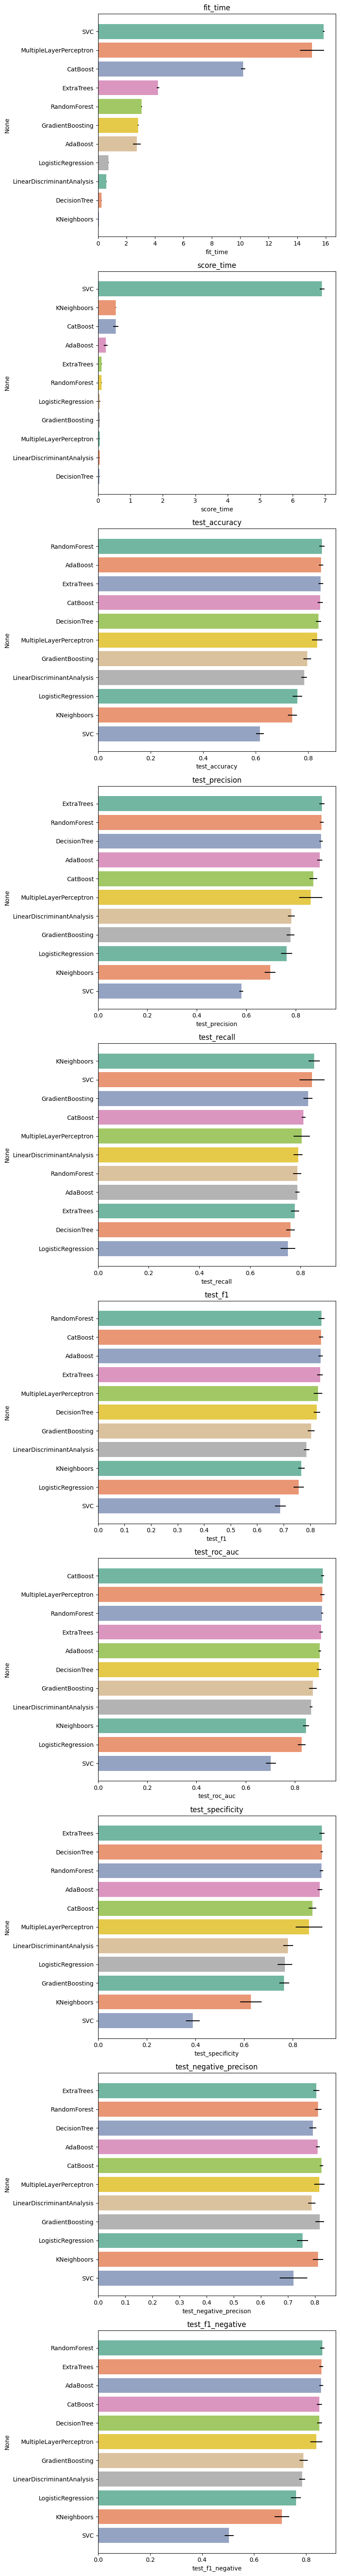

In [209]:
import matplotlib.pyplot as plt

orders = [fit_time_order,score_time_order, test_accuracy_order, prec_order, rec_order, f1_order, roc_order,specificity_order, negative_precision_order, f1_negative_order]

# Define the number of rows and columns
num_metrics = len(orders)
num_rows = num_metrics
num_cols = 1

# Create subplots
fig, ax = plt.subplots(num_rows, num_cols, figsize=(8, 6*num_metrics))

# Iterate over each metric
for i, metric in enumerate(cv_res_df_resampled.columns):
    # Plot the bar plot on the respective subplot
    sns.barplot(x=cv_res_df_resampled[metric], y=cv_res_df_resampled.index, data=cv_res_df_resampled, palette="Set2", orient="h", order=orders[i], ax=ax[i])
    x_error = cv_std_df_resampled[metric] 
    
    # Add error bars
    ax[i].errorbar(x=cv_res_df_resampled[metric], y=cv_res_df_resampled.index, xerr=[x_error], fmt='none', c='black')
    
    ax[i].set_title(metric)
    

plt.tight_layout()
plt.show()


### Hyperparameter tuning for best models.

In [416]:
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size = 0.2, random_state = 54, stratify=y_train_resampled)

In [417]:
from sklearn.model_selection import GridSearchCV

# ExtraTrees

# Define the parameter grid
extra_trees_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize ExtraTreesClassifier
extra_trees = ExtraTreesClassifier(random_state=random_state)

# Initialize GridSearchCV
extra_trees_grid_search = GridSearchCV(extra_trees, extra_trees_param_grid, cv=kfold, scoring='precision', n_jobs=-1, verbose=1)

# Perform grid search
extra_trees_grid_search.fit(X_train, y_train)

# Get the best hyperparameters
extra_trees_best_params = extra_trees_grid_search.best_params_
extra_trees_precision = extra_trees_grid_search.best_score_
extra_trees_best_model = extra_trees_grid_search.best_estimator_

Fitting 5 folds for each of 135 candidates, totalling 675 fits


In [213]:
extra_trees_best_params

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [214]:
extra_trees_precision

0.8995837413063574

In [216]:
# DecisionTree
# Define the parameter grid
decision_tree_param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(random_state=random_state)

# Initialize GridSearchCV
decision_tree_grid_search = GridSearchCV(decision_tree, decision_tree_param_grid, cv=kfold, scoring='precision', n_jobs=-1, verbose=1)

# Perform grid search
decision_tree_grid_search.fit(X_train, y_train)

# Get the best hyperparameters
decision_tree_best_params = decision_tree_grid_search.best_params_
decision_tree_precision = decision_tree_grid_search.best_score_
decision_tree_best_model = decision_tree_grid_search.best_estimator_

Fitting 5 folds for each of 45 candidates, totalling 225 fits


In [217]:
decision_tree_precision

0.904151660160006

In [218]:
decision_tree_best_params

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [219]:
#  Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GradientBoostingClassifier
random_forest = RandomForestClassifier(random_state=54)

# Create the GridSearchCV object
gs_random_forest = GridSearchCV(random_forest, param_grid=rf_param_grid, cv=kfold, scoring='precision', n_jobs=-1, verbose=1)

# Perform the grid search
gs_random_forest.fit(X_train, y_train)

# Get the best parameters and the best score
gs_random_forest_best_params = gs_random_forest.best_params_
gs_random_forest_precision = gs_random_forest.best_score_
rf_best_model = gs_random_forest.best_estimator_


Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [220]:
gs_random_forest_precision

0.9031414792980726

In [ ]:
#CatBoost
catboost_param_grid = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [None, 3, 5, 7]
}

#Initialize CatBoost classifier
catboost = CatBoostClassifier()

#Initialize GridSearchCV
catboost_grid_search = GridSearchCV(catboost, catboost_param_grid, cv=kfold, scoring='precision', n_jobs=-1, verbose=1)

#Perform grid search
catboost_grid_search.fit(X_train, y_train, verbose=False)

#Get the best hyperparameters
catboost_best_params = catboost_grid_search.best_params_
catboost_best_precision = catboost_grid_search.best_score_
catboost_best_model = catboost_grid_search.best_estimator_


In [222]:
print(catboost_best_params)
catboost_best_precision


{'depth': 7, 'iterations': 200, 'learning_rate': 0.2}


0.8857114538440424

In [223]:
# Gradient Boosting
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Create the GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(random_state=42)

# Create the GridSearchCV object
gs_gb_clf = GridSearchCV(estimator=gb_clf, param_grid=gb_param_grid, cv=kfold, scoring=f1_negative_scorer, n_jobs=-1, verbose=1)

# Perform the grid search
gs_gb_clf.fit(X_train, y_train)

# Get the best parameters and the best score
gb_best_params = gs_gb_clf.best_params_
gb_best_score = gs_gb_clf.best_score_
gb_best_model = gs_gb_clf.best_estimator_


Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [224]:
gb_best_score

0.8471263620433953

In [225]:
# Logistic Regression
# Define the parameter grid
logistic_regression_param_grid = {
    'penalty': ['l2'],
    'C': [100],
    'solver': ['liblinear'],
    'max_iter': [50]
}

# Initialize Logistic Regression classifier
logistic_regression = LogisticRegression(random_state=random_state)

# Initialize GridSearchCV
logistic_regression_grid_search = GridSearchCV(logistic_regression, logistic_regression_param_grid, cv=kfold, scoring='precision', n_jobs=-1, verbose=1)

# Perform grid search
logistic_regression_grid_search.fit(X_train, y_train)

# Get the best hyperparameters
logistic_regression_best_params = logistic_regression_grid_search.best_params_
logistic_regression_precision = logistic_regression_grid_search.best_score_
logistic_regression_best_model = logistic_regression_grid_search.best_estimator_


Fitting 5 folds for each of 1 candidates, totalling 5 fits


logistic_regression_best_params:
{'C': 100, 'max_iter': 50, 'penalty': 'l2', 'solver': 'liblinear'}

In [226]:
print(logistic_regression_best_params)
logistic_regression_precision

{'C': 100, 'max_iter': 50, 'penalty': 'l2', 'solver': 'liblinear'}


0.789826379875932

### Plot learning curves

Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.

In [227]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='precision')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
    

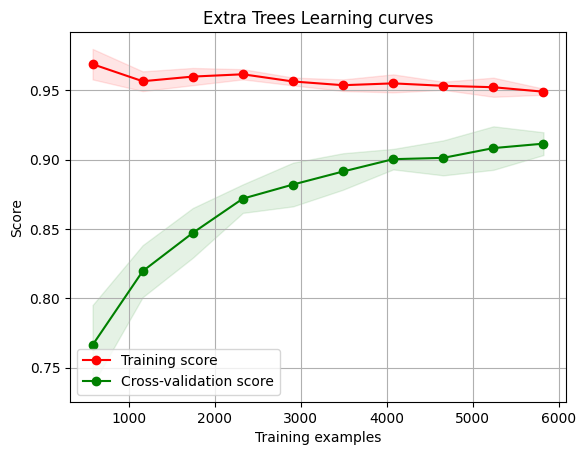

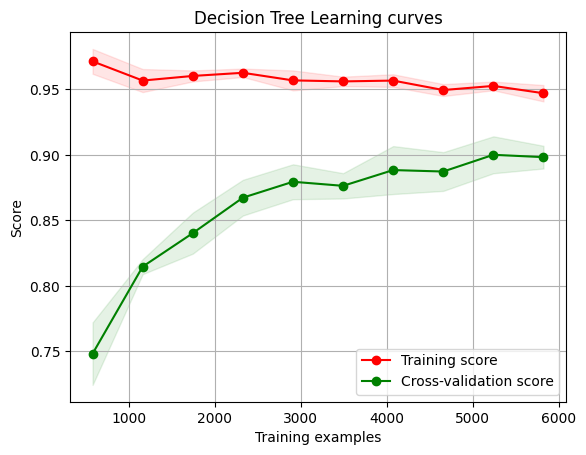

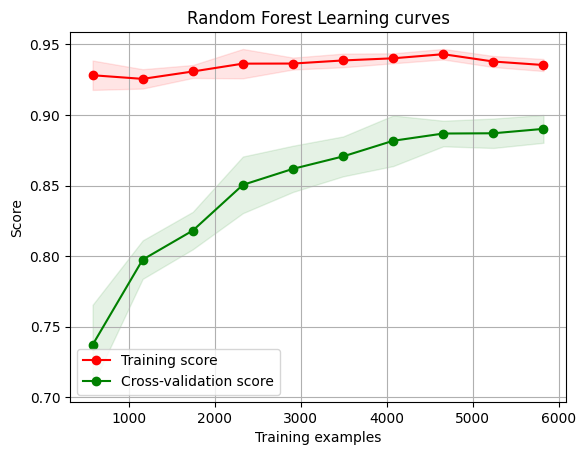

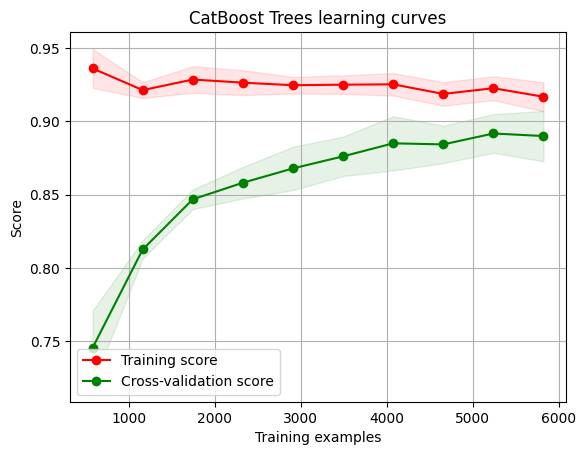

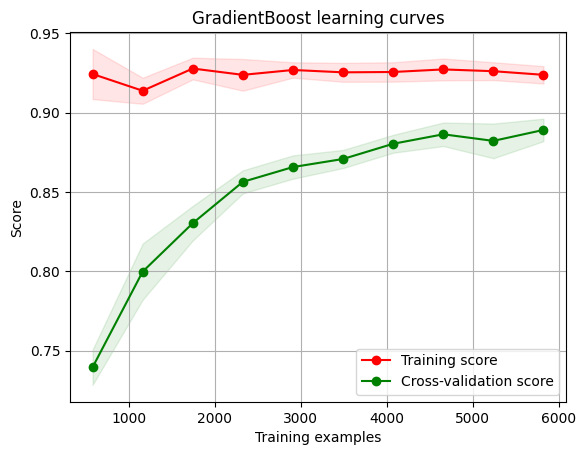

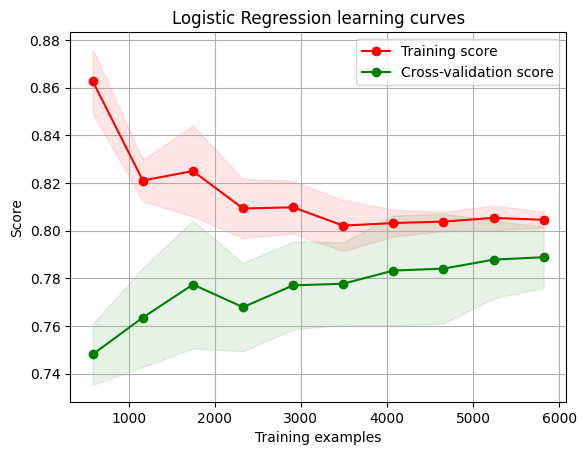

In [228]:
plot_learning_curve(extra_trees_best_model,"Extra Trees Learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(decision_tree_best_model,"Decision Tree Learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(rf_best_model,"Random Forest Learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(catboost_best_model,"CatBoost Trees learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(gb_best_model,"GradientBoost learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(logistic_regression_best_model,"Logistic Regression learning curves",X_train,y_train,cv=kfold)

plt.show()

### Learning curve plots summary

When a model starts with very few examples, it can easily memorize the training data, which is why you see a high score at the beginning of the training curve. This is indeed a sign of overfitting when the model is trained on a very small dataset.
ith just one sample in a 2D space, a model like linear regression can indeed fit a line perfectly through that point, resulting in zero loss because the model's prediction perfectly matches the single data point available. Similarly, a decision tree wouldn't need to make any splits because there is nothing to distinguish—there's only one class or value to predict.

Adding More Samples: As you introduce more samples, the scenario changes. With exactly two points, a linear regression model can still potentially fit a perfect line assuming the points are linearly related. However, with three or more points, it becomes increasingly unlikely that all points lie exactly on the same line, introducing the concept of loss or error in the model's predictions. For a decision tree, more samples mean it may start to make splits to differentiate between the different outputs or classes of the samples.

As more data is added, the model is exposed to more variation, and thus, it becomes harder for it to fit the training data perfectly. Consequently, the training score typically decreases. However, during this process, the model is learning to generalize better, which is why the cross-validation score usually improves with more data. This is the desired behavior as it indicates that the model is learning to generalize from a larger set of data rather than memorizing a small dataset.

The fact that the training curve starts high and decreases (to a point) while the cross-validation curve starts low and increases (also to a point) is perfectly normal for well-functioning models. Over time, ideally, the two curves should converge or at least reach a point where they become parallel, showing that adding more data doesn't significantly change the model's ability to generalize, which seems to be happeningour w
our models.

### Feature importance of the tree-based classifiers

In order to see the most informative features for the prediction of incoming goods, I displayed the feature importance for the 4 tree based classifiers.

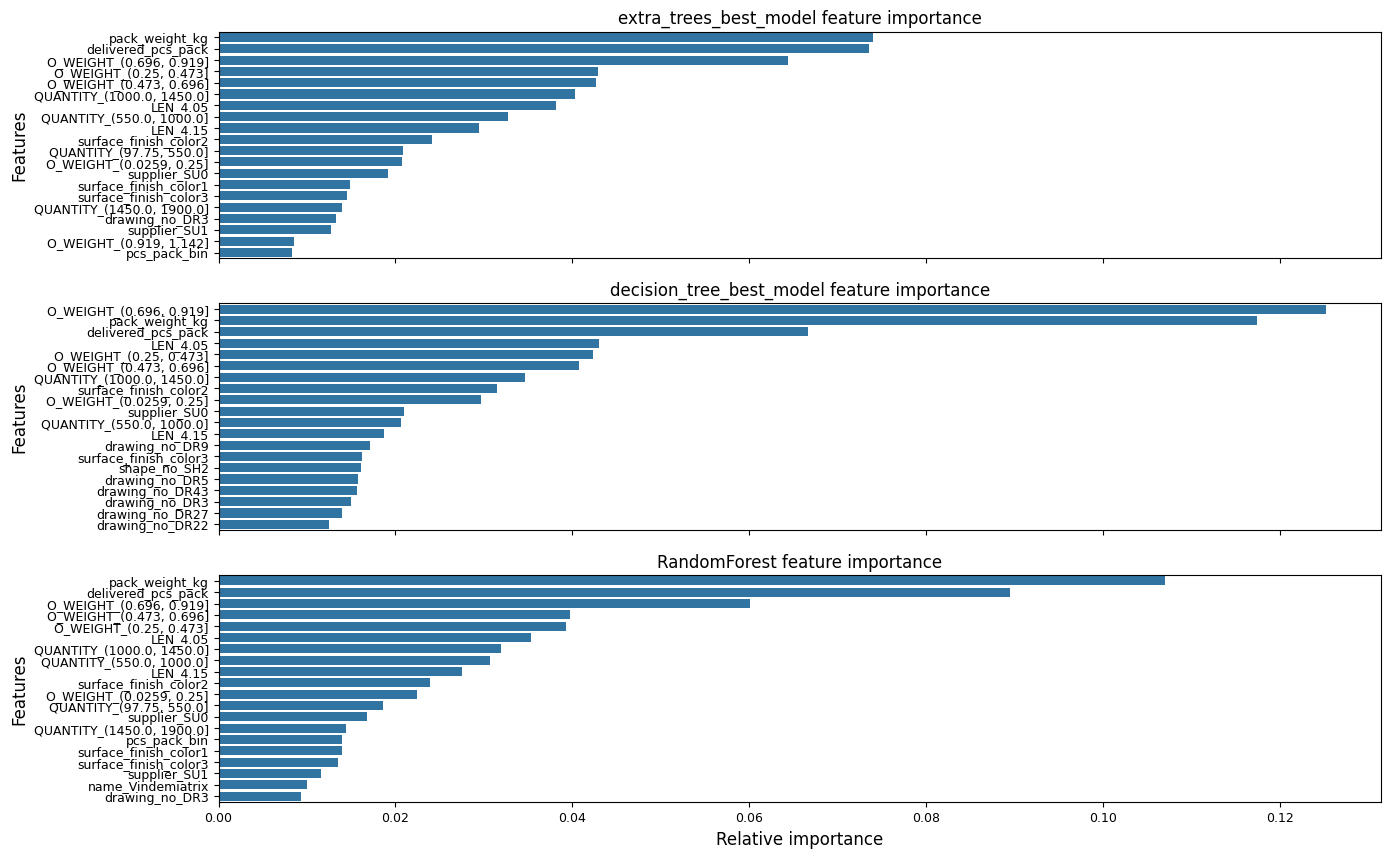

In [229]:
nrows = 3
ncols = 1
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,10))

names_classifiers = [('extra_trees_best_model', extra_trees_best_model),('decision_tree_best_model', decision_tree_best_model),('RandomForest', rf_best_model)]

nclassifier = 0
for row in range(nrows):
    name = names_classifiers[nclassifier][0]
    classifier = names_classifiers[nclassifier][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:20]
    
    g = sns.barplot(y=X_train.columns[indices][:20],x = classifier.feature_importances_[indices][:20] , orient='h',ax=axes[row])
    g.set_xlabel("Relative importance",fontsize=12)
    g.set_ylabel("Features",fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(name + " feature importance")
    nclassifier += 1

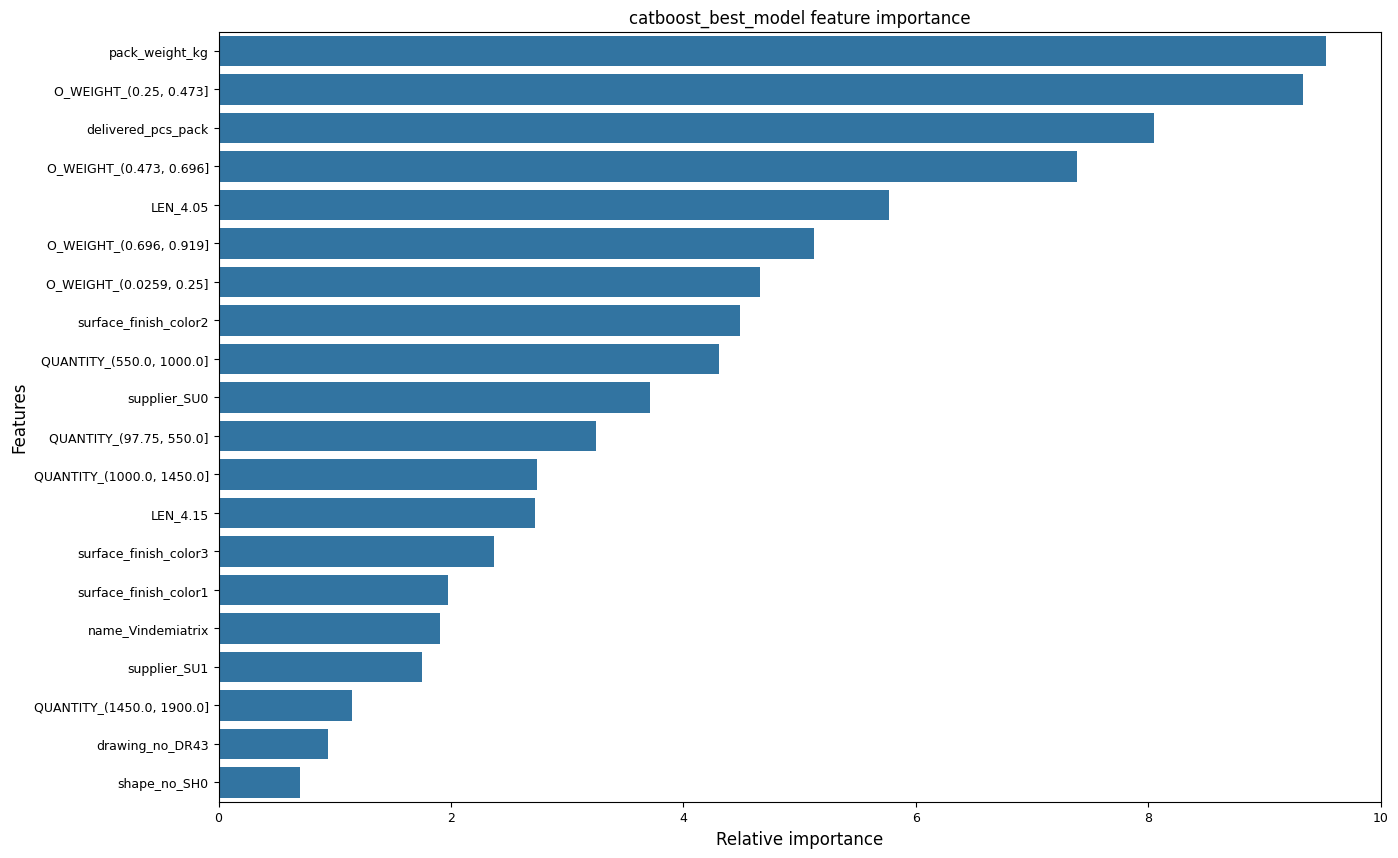

In [230]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,10))

names_classifiers = [('catboost_best_model', catboost_best_model)]

nclassifier = 0


name = names_classifiers[nclassifier][0]
classifier = names_classifiers[nclassifier][1]
indices = np.argsort(classifier.feature_importances_)[::-1][:20]

g = sns.barplot(y=X_train.columns[indices][:20],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes)
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title(name + " feature importance")
nclassifier += 1

Consistency in Feature Importance

The fact that delivered_pcs_pack, and pack_weight_kg came up as a significant feature in both the early and the final versions of the CatBoost model .  It suggests that:

    Stable Feature Significance: Some features are inherently more informative for predicting the target variable, regardless of the model's stage or the balance of the dataset. This indicates a strong, underlying relationship between these features and the target variable.

    Model Robustness to Imbalance: While CatBoost and other advanced machine learning models can be sensitive to imbalanced datasets, their ability to identify key features might remain robust. This can be particularly useful for early-stage model exploration and understanding which features might be worth focusing on for feature engineering or data collection ef

The other features could not be compared because we hot one ecoded them, but this comparison opens a door for revisiting those features, try feature engineering on most important ones and maybe leave them as numerical if they are highly correlated to a target.forts.forts.

### Using chosen models with test set

In [231]:
# Random Forest
rf_pred = rf_best_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_pred)

rf_precision = precision_score(y_test, rf_pred, pos_label=1)
rf_recall = recall_score(y_test, rf_pred, pos_label=1)
rf_f1 = f1_score(y_test, rf_pred, pos_label=1)

rf_precision_neg = precision_score(y_test, rf_pred, pos_label=0)
rf_f1_neg = f1_score(y_test, rf_pred, pos_label=0)
rf_roc_auc = roc_auc_score(y_test, rf_pred)

# Calculate specificity
tn, fp, _, _ = confusion_matrix(y_test, rf_pred).ravel()
rf_specificity = tn / (tn + fp)

# Create DataFrame
results_data = {
    'Accuracy': rf_accuracy,
    'Precision': rf_precision,
    'Recall': rf_recall,
    'F1 Score': rf_f1,
    'ROC AUC': rf_roc_auc,
    'Specificity': rf_specificity,
    'Negative Precision': rf_precision_neg,
    'Negative F1 Score': rf_f1_neg,
}
rf_df = pd.DataFrame(results_data, index=['RandomForest'])

rf_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Specificity,Negative Precision,Negative F1 Score
RandomForest,0.85,0.92,0.76,0.83,0.85,0.94,0.80,0.86


In [232]:
# CatBoost

cat_pred = catboost_best_model.predict(X_test)


cat_accuracy = accuracy_score(y_test, cat_pred)

cat_precision = precision_score(y_test, cat_pred, pos_label=1)
cat_recall = recall_score(y_test, cat_pred, pos_label=1)
cat_f1 = f1_score(y_test, cat_pred, pos_label=1)

cat_precision_neg = precision_score(y_test, cat_pred, pos_label=0)
cat_f1_neg = f1_score(y_test, cat_pred, pos_label=0)

cat_roc_auc = roc_auc_score(y_test, cat_pred)

# Calculate specificity
tn, fp, _, _ = confusion_matrix(y_test, cat_pred).ravel()
cat_specificity = tn / (tn + fp)

# Create DataFrame
results_data = {
    'Accuracy': cat_accuracy,
    'Precision': cat_precision,
    'Recall': cat_recall,
    'F1 Score': cat_f1,
    'ROC AUC': cat_roc_auc,
    'Specificity': cat_specificity,
    'Negative Precision': cat_precision_neg,
    'Negative F1 Score': cat_f1_neg,
}
cat_df = pd.DataFrame(results_data, index=['CatBoost'])

cat_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Specificity,Negative Precision,Negative F1 Score
CatBoost,0.85,0.90,0.79,0.84,0.85,0.91,0.81,0.86


In [418]:
# ExtraTrees
et_pred = extra_trees_best_model.predict(X_test)

et_accuracy = accuracy_score(y_test, et_pred)

et_precision = precision_score(y_test, et_pred, pos_label=1)
et_recall = recall_score(y_test, et_pred, pos_label=1)
et_f1 = f1_score(y_test, et_pred, pos_label=1)

et_precision_neg = precision_score(y_test, et_pred, pos_label=0)
et_f1_neg = f1_score(y_test, et_pred, pos_label=0)
et_roc_auc = roc_auc_score(y_test, et_pred)

# Calculate specificity
tn, fp, _, _ = confusion_matrix(y_test, et_pred).ravel()
et_specificity = tn / (tn + fp)

# Create DataFrame
results_data = {
    'Accuracy': et_accuracy,
    'Precision': et_precision,
    'Recall': et_recall,
    'F1 Score': et_f1,
    'ROC AUC': et_roc_auc,
    'Specificity': et_specificity,
    'Negative Precision': et_precision_neg,
    'Negative F1 Score': et_f1_neg,
}
et_df = pd.DataFrame(results_data, index=['Extra Trees'])

et_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Specificity,Negative Precision,Negative F1 Score
Extra Trees,0.73,0.91,0.74,0.82,0.71,0.69,0.39,0.50


In [234]:
# Decision tree
dt_pred = decision_tree_best_model.predict(X_test)

dt_accuracy = accuracy_score(y_test, dt_pred)

dt_precision = precision_score(y_test, dt_pred, pos_label=1)
dt_recall = recall_score(y_test, dt_pred, pos_label=1)
dt_f1 = f1_score(y_test, dt_pred, pos_label=1)

dt_precision_neg = precision_score(y_test, dt_pred, pos_label=0)
dt_f1_neg = f1_score(y_test, dt_pred, pos_label=0)
roc_auc = roc_auc_score(y_test, dt_pred)

# Calculate specificity
tn, fp, _, _ = confusion_matrix(y_test, dt_pred).ravel()
specificity = tn / (tn + fp)

# Create DataFrame
results_data = {
    'Accuracy': dt_accuracy,
    'Precision': dt_precision,
    'Recall': dt_recall,
    'F1 Score': dt_f1,
    'ROC AUC': roc_auc,
    'Specificity': specificity,
    'Negative Precision': dt_precision_neg,
    'Negative F1 Score': dt_f1_neg,
}
dt_df = pd.DataFrame(results_data, index=['Decision Tree'])

dt_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Specificity,Negative Precision,Negative F1 Score
Decision Tree,0.83,0.91,0.74,0.81,0.83,0.93,0.78,0.85


Combining test results

In [235]:
tested_df = pd.concat([rf_df, et_df, dt_df, cat_df], axis=0)
tested_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Specificity,Negative Precision,Negative F1 Score
RandomForest,0.85,0.92,0.76,0.83,0.85,0.94,0.80,0.86
Extra Trees,0.84,0.92,0.75,0.83,0.84,0.94,0.79,0.86
Decision Tree,0.83,0.91,0.74,0.81,0.83,0.93,0.78,0.85
CatBoost,0.85,0.90,0.79,0.84,0.85,0.91,0.81,0.86


Showing cross validation results on the whole dataset for comparison

In [236]:
cv_res_df_resampled = cv_res_df_resampled.drop(['fit_time',	'score_time'], axis=1)
cv_res_df_resampled.sort_values(by='test_f1_negative', ascending=False)

,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_specificity,test_negative_precison,test_f1_negative
RandomForest,0.85,0.91,0.77,0.83,0.91,0.92,0.80,0.86
ExtraTrees,0.84,0.91,0.75,0.82,0.90,0.93,0.79,0.85
AdaBoost,0.84,0.89,0.76,0.82,0.90,0.91,0.79,0.85
CatBoost,0.84,0.87,0.79,0.83,0.91,0.88,0.81,0.84
MultipleLayerPerceptron,0.83,0.89,0.76,0.82,0.91,0.90,0.79,0.84
DecisionTree,0.83,0.90,0.74,0.81,0.89,0.91,0.78,0.84
KNeighboors,0.80,0.82,0.77,0.79,0.85,0.83,0.78,0.81
GradientBoosting,0.78,0.77,0.81,0.79,0.86,0.76,0.80,0.78
LinearDiscriminantAnalysis,0.77,0.78,0.77,0.77,0.85,0.78,0.77,0.78
LogisticRegression,0.74,0.75,0.73,0.74,0.82,0.75,0.74,0.75


### 7.2 Ensemble modelings

The classifiers except for logistic regression give more or less the same prediction but there is some differences. Theses differences between the 5 classifier predictions are sufficient to consider an ensembling vote.

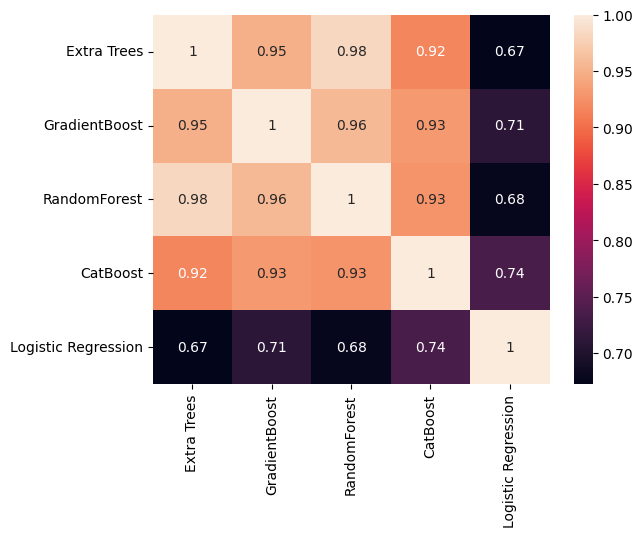

In [237]:
test_IG_ET = pd.Series(extra_trees_best_model.predict(X_test), name='Extra Trees')
test_IG_DT = pd.Series(gb_best_model.predict(X_test), name='GradientBoost')
test_IG_RF = pd.Series(rf_best_model.predict(X_test), name='RandomForest')
test_IG_CB = pd.Series(catboost_best_model.predict(X_test), name='CatBoost')
test_IG_LR = pd.Series(logistic_regression_best_model.predict(X_test), name='Logistic Regression')

# Concatenate all classifier results
ensemble_results = pd.concat([test_IG_ET,test_IG_DT, test_IG_RF,test_IG_CB,test_IG_LR],axis=1)

g= sns.heatmap(ensemble_results.corr(),annot=True)

When choosing models for a voting ensemble, a key consideration is the diversity of errors they make, meaning you generally want models that are not too highly correlated in their predictions.

In [239]:
from sklearn.ensemble import VotingClassifier

votingC = VotingClassifier(estimators=[
    ('ExtraTrees', extra_trees_best_model), ('GradientBoosting', gb_best_model), ('RandomForest', rf_best_model), ('CatBoost', catboost_best_model), ('LogisticRegression',logistic_regression_best_model)], voting='soft', n_jobs=-1)

votingC = votingC.fit(X_train, y_train)


In [240]:
vc_y_pred = votingC.predict(X_test)

vc_accuracy = accuracy_score(y_test, vc_y_pred)

vc_precision = precision_score(y_test, vc_y_pred, pos_label=1)
vc_recall = recall_score(y_test, vc_y_pred, pos_label=1)
vc_f1 = f1_score(y_test, vc_y_pred, pos_label=1)

vc_precision_neg = precision_score(y_test, vc_y_pred, pos_label=0)
vc_f1_neg = f1_score(y_test, vc_y_pred, pos_label=0)
vc_roc_auc = roc_auc_score(y_test, vc_y_pred)

# Calculate specificity
tn, fp, _, _ = confusion_matrix(y_test, vc_y_pred).ravel()
vc_specificity = tn / (tn + fp)

# Create DataFrame
results_data = {
    'Accuracy': vc_accuracy,
    'Precision': vc_precision,
    'Recall': vc_recall,
    'F1 Score': vc_f1,
    'ROC AUC': vc_roc_auc,
    'Specificity': vc_specificity,
    'Negative Precision': vc_precision_neg,
    'Negative F1 Score': vc_f1_neg,
}
votingC_df = pd.DataFrame(results_data, index=['VotingC'])

votingC_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Specificity,Negative Precision,Negative F1 Score
VotingC,0.85,0.91,0.79,0.84,0.85,0.92,0.81,0.86


In [241]:
final_df = pd.concat([votingC_df,cat_df, et_df, rf_df, dt_df ], axis=0)
final_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Specificity,Negative Precision,Negative F1 Score
VotingC,0.85,0.91,0.79,0.84,0.85,0.92,0.81,0.86
CatBoost,0.85,0.90,0.79,0.84,0.85,0.91,0.81,0.86
Extra Trees,0.84,0.92,0.75,0.83,0.84,0.94,0.79,0.86
RandomForest,0.85,0.92,0.76,0.83,0.85,0.94,0.80,0.86
Decision Tree,0.83,0.91,0.74,0.81,0.83,0.93,0.78,0.85


In summary, while all models show comparable performance across various metrics, Voting Classifier and CatBoost slightly outperform the others, suggesting they might be better at handling this particular dataset overall. However, these differences are marginal.

### 7.3 Prediction

In [242]:
from sklearn.metrics import precision_score, recall_score, f1_score

vc_y_proba = votingC.predict_proba(X_test)

# Assuming y_pred_rf contains probabilities for the positive class
positive_class_proba = vc_y_proba[:, 1]  # Assuming the positive class is the first class

# Define a range of thresholds to experiment with
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # Example thresholds, you can adjust as needed

# Initialize a dictionary to store results
threshold_results = {}
threshold_results_recall = {}

# Loop over each threshold
for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (positive_class_proba >= threshold).astype(int)
    
    # Calculate precision for the positive class predictions
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    
    # Store the precision for this threshold
    threshold_results[threshold] = precision
    threshold_results_recall[threshold] = recall
# Print the results
for threshold, precision in threshold_results.items():
    recall = threshold_results_recall[threshold]
    print(f"Threshold: {threshold}, Precision: {precision}, Recall: {recall} ")


Threshold: 0.1, Precision: 0.5546064673581452, Recall: 0.9989010989010989 
Threshold: 0.2, Precision: 0.6605644546147978, Recall: 0.9516483516483516 
Threshold: 0.3, Precision: 0.7607476635514019, Recall: 0.8945054945054945 
Threshold: 0.4, Precision: 0.8411829134720701, Recall: 0.843956043956044 
Threshold: 0.5, Precision: 0.908745247148289, Recall: 0.7879120879120879 
Threshold: 0.6, Precision: 0.9287671232876712, Recall: 0.7450549450549451 
Threshold: 0.7, Precision: 0.9522388059701492, Recall: 0.701098901098901 
Threshold: 0.8, Precision: 0.9611650485436893, Recall: 0.6527472527472528 
Threshold: 0.9, Precision: 0.9689578713968958, Recall: 0.48021978021978023 


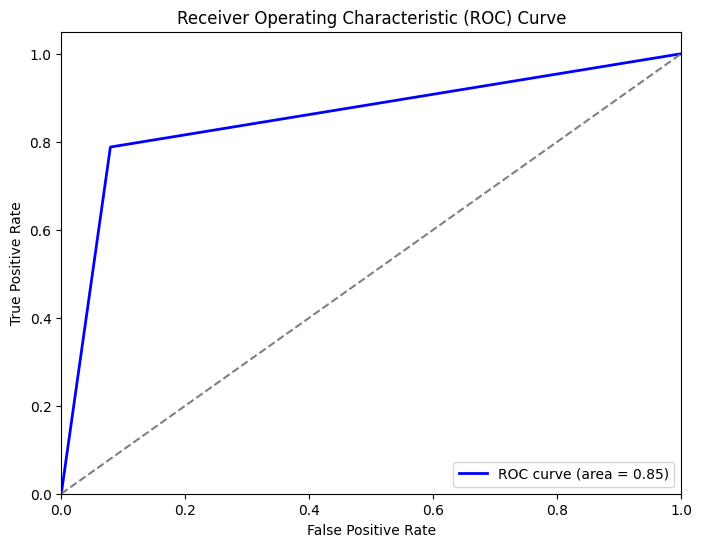

In [243]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, vc_y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


I meant to raise precision metrics i would raise the threshold to 0.7 or 0.8. In last year in data there was only 8% of nok products. This means quality personnel needs to perform quality check on every shipment even when most of them are ok. In business terms together with growing sales and growing amount of ordered goods this means the need of many QC personel to relatively low defects (8% or lower in future years due to positive impact of quality personel on suppliers, etc).
Having higher precision could help mitigate unnecessary controlls  where model is quite confitdent of OK label.

By adjusting the threshold, you can tailor your decision-making process to balance between the risk of missing defective products and the efficiency of your quality control personnel. Increasing the threshold to 0.95 allows you to confidently identify a subset of products as OK, reducing the need for inspection. Then, lowering the threshold back to 0.5 enables you to focus specifically on the products predicted as NOK for inspection, optimizing the allocation of resources and ensuring thorough quality control. This iterative approach, combined with evaluating different threshold choices using relevant metrics, helps you optimize your operational strategies while maintaining product quality and minimizing unnecessary inspections.

In [244]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Convert probabilities to binary predictions based on a threshold (e.g., 0.5)
y_pred_binary = (vc_y_proba[:,1] >= 0.5).astype(int)

# Compute precision, recall, and F1 score for the negative class
precision = precision_score(y_test, y_pred_binary, pos_label=1)
recall = recall_score(y_test, y_pred_binary, pos_label=1)
f1 = f1_score(y_test, y_pred_binary, pos_label=1)
precision_negative = precision_score(y_test, y_pred_binary, pos_label=0)
specificity = recall_score(y_test, y_pred_binary, pos_label=0)
f1_negative = f1_score(y_test, y_pred_binary, pos_label=0)

roc_auc = roc_auc_score(y_test, y_pred_binary)

print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1 Score: {:.3f}".format(f1))

print("Precision (Negative Class): {:.3f}".format(precision_negative))
print("Specificity (Negative Class Recall): {:.3f}".format(specificity))
print("F1 Score (Negative Class): {:.3f}".format(f1_negative))
print("ROC AUC: {:.3f}".format(roc_auc))

Precision: 0.909
Recall: 0.788
F1 Score: 0.844
Precision (Negative Class): 0.813
Specificity (Negative Class Recall): 0.921
F1 Score (Negative Class): 0.863
ROC AUC: 0.854


In [245]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[837  72]
 [193 717]]


### Conclusions

By adjusting our model's prediction thresholds, we've developed effective methods to identify deliveries that are likely okay (OK) and those that are not (NOK), benefiting various company departments:

1. **Threshold at 0.1**: With a threshold of 0.1, we're 99.5% certain we can identify almost a quarter of the problematic deliveries.
2. **Threshold at 0.87**: At a threshold of 0.87, we can confidently say that 96.4% of deliveries marked as good are indeed good.
3. **Threshold at 0.5**: A balanced threshold of 0.5 allows us to be 91% confident about 80% of the deliveries being OK, and 81% confident that nearly all the remaining deliveries are NOK.

These insights offer direct and indirect benefits to various departments within the company, from quality personnel to logistics, R&D, sales, and higher management.

Quality personnel can use the model to prepare for deliveries in advance, adjust inspection levels, and change inspection strategies. Shifting from manual inspections to automated processes for predicted "OK" deliveries could reduce the workload by roughly 50%, while attention can be focused on products predicted as "NOK" for thorough scrutiny where it's needed most. To put it simply, starting with about 6000 records over 6 years, we average 1000 inspections per year. With an 80/20 distribution, approximately 60% of 800 OK deliveries translate to about 500 deliveries. This is a significant reduction in annual workload. Of course, it's not always beneficial to risk having 19 "rotten apples" slip through yearly inspections, not to mention that some production faults might be random due to various factors in production, personnel, or transport. Nevertheless, these insights give us room for decision-making and improvements.

Logistics experts, who are tasked with maintaining shelf stock while minimizing excess inventory, will find the model's predictions invaluable. In the LED profile business, lead times range from 5 to 20 weeks. A "NOK" delivery, particularly one that clients have been eagerly anticipating for up to 20 weeks, could severely disrupt sales and damage client relationships. The risk of waiting such a long period only to receive an unsatisfactory delivery underscores the importance of accurate predictions. Such scenarios emphasize not just the inconvenience but the real possibility of losing clients, making the predictive model's insights not just valuable, but essential for avoiding these critical pitfalls.
With predictive data, supply personnel can make more informed decisions regarding orders, suppliers, and quantities and can explore alternative sourcing strategies to mitigate these risks.

R&D teams can analyze common features of "NOK" products to improve future designs and packaging solutions. Sales teams would benefit from a more reliable supply chain and enhanced customer relations.

For higher management, the model offers a means to streamline operations, reduce manual quality checks, optimize workforce allocation, and minimize costs associated with handling complaints from suppliers and customers.

In summary, the predictive model is a powerful tool for enhancing efficiency, optimizing resources, and driving improvements across the company's operations.

There's also room to improve the model. An interesting next step would be to explore feature engineering, such as combining shape with supplier or color features to see their combined impact on ON_NOK mean values. Our base tree models highlight the most important features for optimal splitting, which is a good starting point for further refinement. Another area for improvement is to examine the errors in predictions more closely to identify patterns and devise strategies to mitigate them.

All in all this predictive model marks a step toward more intelligent resource optimization and improved decision-making throughout our operations.


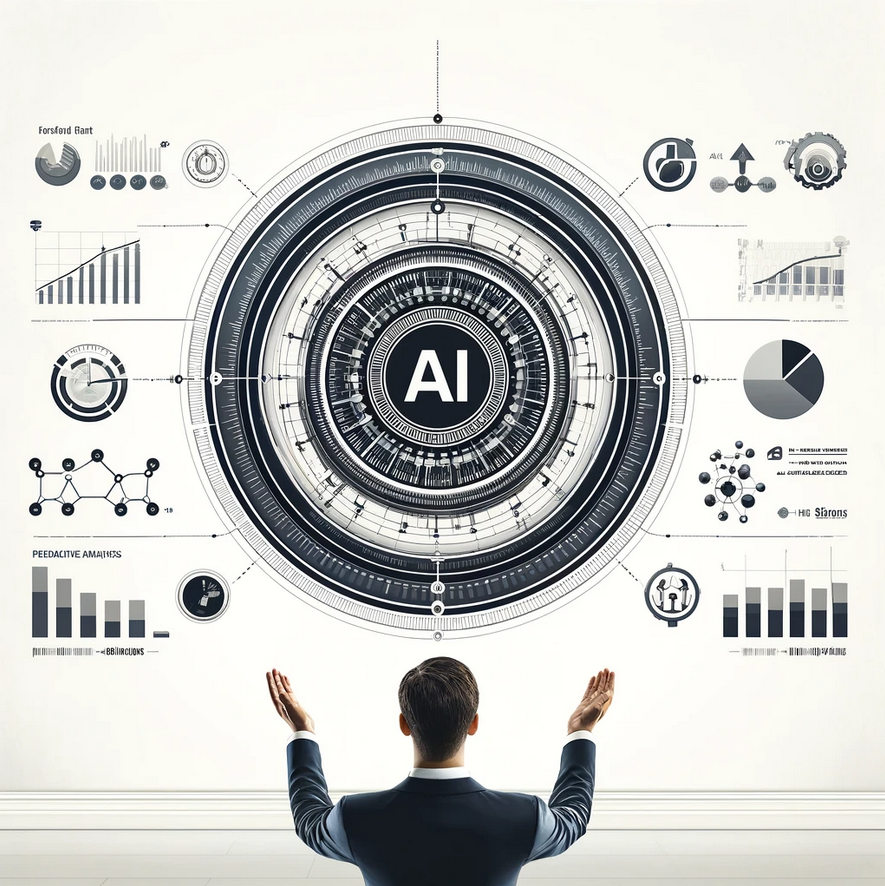
